In [1]:
### Prepare module structure ###

import sys
sys.path.append("../")

In [2]:
### IMPORT ###

import numpy as np
import math
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim

import time

import matplotlib.pyplot as plt
%matplotlib inline

from util import *
import data
import models

# auto reload imports on local changes
%load_ext autoreload
%autoreload 2
print(torch.__version__)

1.0.0


In [3]:
### Check device ###

USE_GPU = True

dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    # TODO: Change to CPU used!
    device = torch.device('cuda:1')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda:1


In [4]:
def plot_magn(magn):
    scaled = magn ** 0.1
    plot(scaled / torch.max(scaled))
    
def plot_phase(phase):
    plot((phase + math.pi) / (2 * math.pi))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


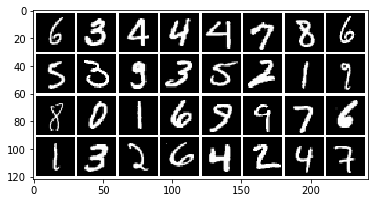

torch.Size([32, 1, 28, 28])


In [5]:
### LOAD DATA ###

dataset = 'mnist'
dataloader, imsize = data.load(dataset, path='/home/shared/phase-retrieval/data/' + dataset, batch_size=32)

sample = next(iter(dataloader['train']))
sample_ft =  torch.rfft(sample, 2, onesided=False)
sample_magnitudes = torch.sqrt(torch.sum(sample_ft ** 2, -1))
sample_phases = torch.atan2(sample_ft[..., 1], sample_ft[..., 0])

plot_grid(sample)
print(sample_magnitudes.shape)

Magnitude:


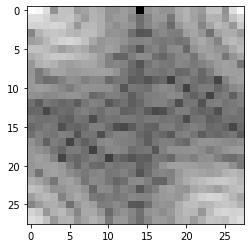

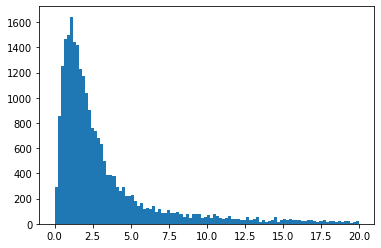

Phase:


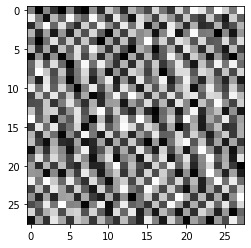

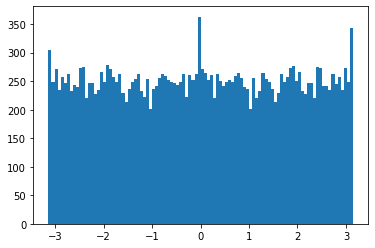

In [6]:
# Value distributions of magnitude and phase for the first sample

print("Magnitude:")
plot_magn(sample_magnitudes[0, 0])
plt.hist(sample_magnitudes.reshape(-1), bins=100, range=(0, 20))
plt.show()
print("Phase:")
plot_phase(sample_phases[0, 0])
plt.hist(sample_phases.reshape(-1), bins=100)
plt.show()

In [7]:
# Check for shapes of rfft transformation in Fourier and signal domain

sample_ft1 = torch.rfft(sample, 2, onesided=True)
print(sample_ft1.shape)
sample1 = torch.irfft(sample_ft1, 2, onesided=True, signal_sizes=(28, 28))
print(sample1[0].shape)

torch.Size([32, 1, 28, 15, 2])
torch.Size([1, 28, 28])


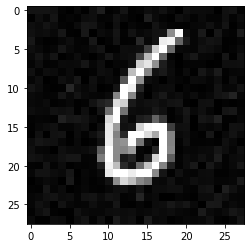

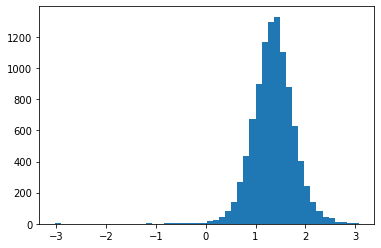

In [8]:
# Show how a small change in the signal space can disturb a specific phase
noise_level = 0.05
########
plot(sample[0] + noise_level * torch.abs(torch.randn(sample[0].shape)))

ph0 = []
for i in range(10000):
    ft = torch.rfft(sample[0] + noise_level * torch.randn(sample[0].shape), 2, onesided=True)
    ph0.append(torch.atan2(ft[..., 1], ft[..., 0])[0, 10, 10])
    
plt.hist(ph0, bins=50)
plt.show()

Gaussian in the signal domain cause Gaussian noise for the phases. But circular!

---

In [9]:
# Define different distances (expecting real phases)

def l2(phase1, phase2):
    return torch.mean((phase1 - phase2) ** 2)

def cmplx_l2(magn, phase1, phase2):
    vec1 = torch.stack([torch.cos(phase1), torch.sin(phase1)], dim=-1)
    vec2 = torch.stack([torch.cos(phase2), torch.sin(phase2)], dim=-1)
    return torch.mean((magn ** 2) * torch.sum((vec1 - vec2) ** 2, -1))

# equals cmpls_l2 for magn = 1
def fourier_l2(magn, phase1, phase2):
    return 2 * torch.mean((magn ** 2) * (1 - torch.cos(phase1 - phase2)))

Sample 1


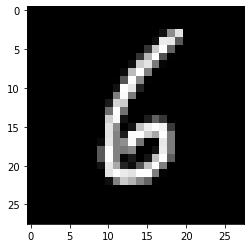

Sample 1 with small noise


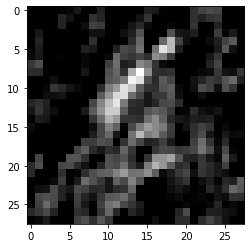

Sample 1 noise vs. Sample 1
Real L2 39.64919662475586
###########################
L2 5.845766067504883
Cmplx L2 39.64918899536133
Fourier L2 39.64918899536133


In [10]:
sample1 = sample[0]

sample1_ft = torch.rfft(sample1, 2, onesided=False)
sample1_phases = torch.atan2(sample1_ft[..., 1], sample1_ft[..., 0])
sample1_magn = torch.norm(sample1_ft, dim=-1)

sample1_noise = sample1 + 1.0 * torch.randn(sample1.shape)
sample1_noise_ft = torch.rfft(sample1_noise, 2, onesided=False)
sample1_noise_ft = sample1_magn[..., None] * (sample1_noise_ft /
                                              torch.sqrt(torch.sum(sample1_noise_ft ** 2, -1))[..., None])

sample1_noise_phases = torch.atan2(sample1_noise_ft[..., 1], sample1_noise_ft[..., 0])
sample1_noise = torch.irfft(sample1_noise_ft, 2, onesided=False)

print("Sample 1")
plot(sample1)

print("Sample 1 with small noise")
plot(sample1_noise)


print("Sample 1 noise vs. Sample 1")
print("Real L2", torch.sum((sample1 - sample1_noise) ** 2).item())
print("###########################")
print("L2", l2(sample1_phases, sample1_noise_phases).item())
print("Cmplx L2", cmplx_l2(sample1_magn, sample1_phases, sample1_noise_phases).item())
print("Fourier L2", fourier_l2(sample1_magn, sample1_phases, sample1_noise_phases).item())

In [11]:
# Fully connected image network
class FCNet(nn.Module):

    __constants__ = ['mean', 'std']

    def __init__(self, imsize=(1, 28, 28), outsize=None, h=2048, mean=None, std=None):
        super(FCNet, self).__init__()
        print("Version 0.4")
        self.imsize = imsize
        if outsize is None:
            self.outsize = imsize
        else:
            self.outsize = outsize
        
        if mean is None:
            self.register_buffer('mean', torch.zeros(imsize))
        else:
            self.register_buffer('mean', torch.Tensor(mean))

        if std is None:
            self.register_buffer('std', torch.ones(imsize))
        else:
            self.register_buffer('std', torch.Tensor(std))
        
        self.layers = nn.Sequential(
            nn.Linear(imsize[0] * imsize[1] * imsize[2], h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h,h),
            nn.BatchNorm1d(h),
            nn.ReLU(),
            nn.Linear(h, self.outsize[0] * self.outsize[1] * self.outsize[2]),
            nn.Tanh()
        )
        
    def forward(self, x):
    
        N = x.shape[0]

        out = math.pi * self.layers(x.view(N, -1))
        return out.view(N, *self.outsize)

In [12]:
def calc_fourier(x):
    ft =  torch.rfft(x, 2, onesided=False)
    mags = torch.sqrt(torch.sum(ft ** 2, -1) + 1e-16)
    phs = torch.atan2(ft[..., 1], ft[..., 0])
    return mags, phs

In [13]:
# Define loss

def gen_loss(magn, phase1, phase2):
    return 2 * torch.mean((magn ** 2) * (1 - torch.cos(phase1 - phase2)))
    #return torch.mean((phase1 - phase2) ** 2)

In [14]:
### Create new models ###

gen = FCNet(imsize=(1, 28, 28), outsize=(1, 28, 28), h=2048)

Version 0.4


In [15]:
# Set training parameters

history = []
opt = optim.Adam(gen.parameters(), lr=1e-3)

In [16]:
# Initial loss

gen = gen.to(device)
sample = sample.to(device)
sample_magn, sample_phs = calc_fourier(sample)

pred_phs = gen(sample_magn)

loss = gen_loss(sample_magn, pred_phs, sample_phs)

print("Generator loss:", loss.item())

Generator loss: 166.75875854492188


In [17]:
def train_model(model, optimizer, device, loader_train, epochs=1):

    # move the model parameters to CPU/GPU
    model = model.to(device=device)
    
    history = []
    
    for e in range(epochs):

        for t, x in enumerate(loader_train):
            # put model to training mode
            model.train()
            
            # move x to device and reduce to magnitude information in fourier space
            x = x.to(device=device)

            magn, phs = calc_fourier(x)

            # compute loss as pixel wise distance to original input
            pred_phs = model(magn)
            
            loss = gen_loss(magn, pred_phs, phs)
            #loss = torch.mean((x - out_real)**2) + torch.mean((phases - out_phases)**2)
            history.append(loss.item())

            # perform backprop and learning step
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step()

            if t % 100 == 0:
                print("epoch: {:2} \t step:{} \t loss: {:3.4}".format(e+1, t, history[-1]))
                
        plt.plot(history)
        plt.show()
                
    return history

epoch:  1 	 step:0 	 loss: 161.5
epoch:  1 	 step:100 	 loss: 67.52
epoch:  1 	 step:200 	 loss: 67.05
epoch:  1 	 step:300 	 loss: 62.04
epoch:  1 	 step:400 	 loss: 59.47
epoch:  1 	 step:500 	 loss: 57.43
epoch:  1 	 step:600 	 loss: 54.35
epoch:  1 	 step:700 	 loss: 53.97
epoch:  1 	 step:800 	 loss: 45.75
epoch:  1 	 step:900 	 loss: 50.45
epoch:  1 	 step:1000 	 loss: 49.82
epoch:  1 	 step:1100 	 loss: 50.87
epoch:  1 	 step:1200 	 loss: 47.77
epoch:  1 	 step:1300 	 loss: 52.16
epoch:  1 	 step:1400 	 loss: 44.42
epoch:  1 	 step:1500 	 loss: 53.42
epoch:  1 	 step:1600 	 loss: 45.7
epoch:  1 	 step:1700 	 loss: 45.51
epoch:  1 	 step:1800 	 loss: 42.3


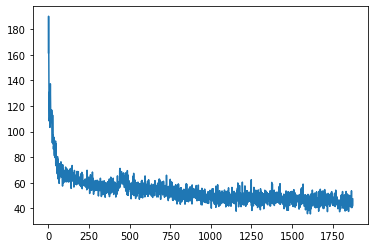

epoch:  2 	 step:0 	 loss: 46.22
epoch:  2 	 step:100 	 loss: 46.12
epoch:  2 	 step:200 	 loss: 48.33
epoch:  2 	 step:300 	 loss: 48.96
epoch:  2 	 step:400 	 loss: 42.82
epoch:  2 	 step:500 	 loss: 41.74
epoch:  2 	 step:600 	 loss: 41.24
epoch:  2 	 step:700 	 loss: 47.26
epoch:  2 	 step:800 	 loss: 43.68
epoch:  2 	 step:900 	 loss: 49.91
epoch:  2 	 step:1000 	 loss: 42.32
epoch:  2 	 step:1100 	 loss: 44.84
epoch:  2 	 step:1200 	 loss: 43.56
epoch:  2 	 step:1300 	 loss: 44.71
epoch:  2 	 step:1400 	 loss: 40.66
epoch:  2 	 step:1500 	 loss: 41.46
epoch:  2 	 step:1600 	 loss: 43.0
epoch:  2 	 step:1700 	 loss: 36.97
epoch:  2 	 step:1800 	 loss: 41.24


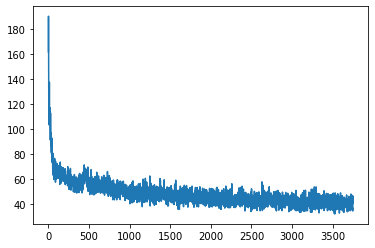

epoch:  3 	 step:0 	 loss: 37.35
epoch:  3 	 step:100 	 loss: 36.28
epoch:  3 	 step:200 	 loss: 39.51
epoch:  3 	 step:300 	 loss: 44.28
epoch:  3 	 step:400 	 loss: 36.34
epoch:  3 	 step:500 	 loss: 34.13
epoch:  3 	 step:600 	 loss: 37.47
epoch:  3 	 step:700 	 loss: 36.99
epoch:  3 	 step:800 	 loss: 31.91
epoch:  3 	 step:900 	 loss: 37.29
epoch:  3 	 step:1000 	 loss: 37.03
epoch:  3 	 step:1100 	 loss: 41.64
epoch:  3 	 step:1200 	 loss: 32.18
epoch:  3 	 step:1300 	 loss: 38.28
epoch:  3 	 step:1400 	 loss: 39.15
epoch:  3 	 step:1500 	 loss: 36.82
epoch:  3 	 step:1600 	 loss: 39.35
epoch:  3 	 step:1700 	 loss: 33.03
epoch:  3 	 step:1800 	 loss: 35.54


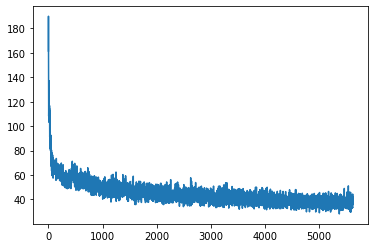

epoch:  4 	 step:0 	 loss: 36.96
epoch:  4 	 step:100 	 loss: 35.88
epoch:  4 	 step:200 	 loss: 32.74
epoch:  4 	 step:300 	 loss: 35.95
epoch:  4 	 step:400 	 loss: 34.01
epoch:  4 	 step:500 	 loss: 37.54
epoch:  4 	 step:600 	 loss: 29.92
epoch:  4 	 step:700 	 loss: 29.95
epoch:  4 	 step:800 	 loss: 34.74
epoch:  4 	 step:900 	 loss: 38.97
epoch:  4 	 step:1000 	 loss: 30.21
epoch:  4 	 step:1100 	 loss: 35.72
epoch:  4 	 step:1200 	 loss: 31.96
epoch:  4 	 step:1300 	 loss: 38.4
epoch:  4 	 step:1400 	 loss: 35.45
epoch:  4 	 step:1500 	 loss: 30.03
epoch:  4 	 step:1600 	 loss: 36.75
epoch:  4 	 step:1700 	 loss: 33.82
epoch:  4 	 step:1800 	 loss: 38.55


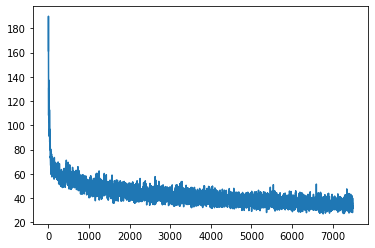

epoch:  5 	 step:0 	 loss: 33.17
epoch:  5 	 step:100 	 loss: 34.49
epoch:  5 	 step:200 	 loss: 35.07
epoch:  5 	 step:300 	 loss: 35.55
epoch:  5 	 step:400 	 loss: 38.15
epoch:  5 	 step:500 	 loss: 33.75
epoch:  5 	 step:600 	 loss: 34.73
epoch:  5 	 step:700 	 loss: 33.82
epoch:  5 	 step:800 	 loss: 40.87
epoch:  5 	 step:900 	 loss: 31.86
epoch:  5 	 step:1000 	 loss: 33.66
epoch:  5 	 step:1100 	 loss: 33.11
epoch:  5 	 step:1200 	 loss: 36.58
epoch:  5 	 step:1300 	 loss: 34.14
epoch:  5 	 step:1400 	 loss: 33.71
epoch:  5 	 step:1500 	 loss: 32.21
epoch:  5 	 step:1600 	 loss: 32.97
epoch:  5 	 step:1700 	 loss: 35.02
epoch:  5 	 step:1800 	 loss: 31.52


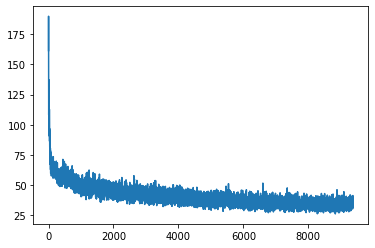

epoch:  6 	 step:0 	 loss: 34.88
epoch:  6 	 step:100 	 loss: 32.37
epoch:  6 	 step:200 	 loss: 25.1
epoch:  6 	 step:300 	 loss: 35.16
epoch:  6 	 step:400 	 loss: 33.85
epoch:  6 	 step:500 	 loss: 30.19
epoch:  6 	 step:600 	 loss: 30.14
epoch:  6 	 step:700 	 loss: 30.23
epoch:  6 	 step:800 	 loss: 26.22
epoch:  6 	 step:900 	 loss: 25.63
epoch:  6 	 step:1000 	 loss: 29.99
epoch:  6 	 step:1100 	 loss: 36.12
epoch:  6 	 step:1200 	 loss: 31.67
epoch:  6 	 step:1300 	 loss: 34.83
epoch:  6 	 step:1400 	 loss: 35.62
epoch:  6 	 step:1500 	 loss: 31.79
epoch:  6 	 step:1600 	 loss: 35.71
epoch:  6 	 step:1700 	 loss: 35.85
epoch:  6 	 step:1800 	 loss: 35.72


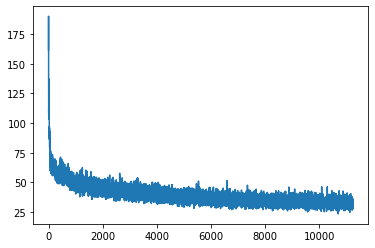

epoch:  7 	 step:0 	 loss: 32.91
epoch:  7 	 step:100 	 loss: 30.38
epoch:  7 	 step:200 	 loss: 29.58
epoch:  7 	 step:300 	 loss: 36.84
epoch:  7 	 step:400 	 loss: 31.06
epoch:  7 	 step:500 	 loss: 30.79
epoch:  7 	 step:600 	 loss: 35.8
epoch:  7 	 step:700 	 loss: 36.34
epoch:  7 	 step:800 	 loss: 32.64
epoch:  7 	 step:900 	 loss: 31.44
epoch:  7 	 step:1000 	 loss: 31.53
epoch:  7 	 step:1100 	 loss: 34.14
epoch:  7 	 step:1200 	 loss: 29.02
epoch:  7 	 step:1300 	 loss: 29.8
epoch:  7 	 step:1400 	 loss: 27.03
epoch:  7 	 step:1500 	 loss: 30.34
epoch:  7 	 step:1600 	 loss: 29.63
epoch:  7 	 step:1700 	 loss: 28.38
epoch:  7 	 step:1800 	 loss: 26.85


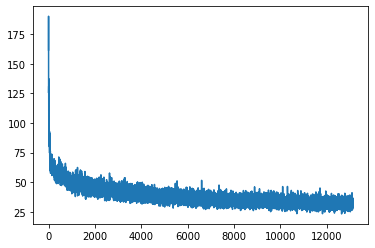

epoch:  8 	 step:0 	 loss: 32.83
epoch:  8 	 step:100 	 loss: 27.75
epoch:  8 	 step:200 	 loss: 32.11
epoch:  8 	 step:300 	 loss: 33.97
epoch:  8 	 step:400 	 loss: 29.3
epoch:  8 	 step:500 	 loss: 43.94
epoch:  8 	 step:600 	 loss: 32.3
epoch:  8 	 step:700 	 loss: 26.92
epoch:  8 	 step:800 	 loss: 34.9
epoch:  8 	 step:900 	 loss: 34.8
epoch:  8 	 step:1000 	 loss: 29.71
epoch:  8 	 step:1100 	 loss: 25.95
epoch:  8 	 step:1200 	 loss: 27.79
epoch:  8 	 step:1300 	 loss: 27.85
epoch:  8 	 step:1400 	 loss: 32.19
epoch:  8 	 step:1500 	 loss: 37.47
epoch:  8 	 step:1600 	 loss: 34.3
epoch:  8 	 step:1700 	 loss: 30.55
epoch:  8 	 step:1800 	 loss: 28.88


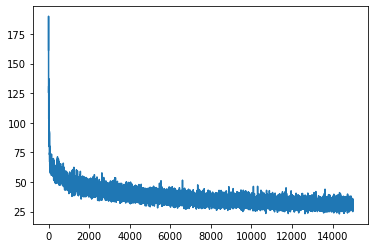

epoch:  9 	 step:0 	 loss: 30.2
epoch:  9 	 step:100 	 loss: 29.88
epoch:  9 	 step:200 	 loss: 35.18
epoch:  9 	 step:300 	 loss: 24.99
epoch:  9 	 step:400 	 loss: 27.78
epoch:  9 	 step:500 	 loss: 29.81
epoch:  9 	 step:600 	 loss: 31.97
epoch:  9 	 step:700 	 loss: 31.54
epoch:  9 	 step:800 	 loss: 26.6
epoch:  9 	 step:900 	 loss: 32.51
epoch:  9 	 step:1000 	 loss: 29.68
epoch:  9 	 step:1100 	 loss: 30.89
epoch:  9 	 step:1200 	 loss: 23.73
epoch:  9 	 step:1300 	 loss: 32.65
epoch:  9 	 step:1400 	 loss: 32.48
epoch:  9 	 step:1500 	 loss: 32.45
epoch:  9 	 step:1600 	 loss: 29.32
epoch:  9 	 step:1700 	 loss: 28.73
epoch:  9 	 step:1800 	 loss: 31.37


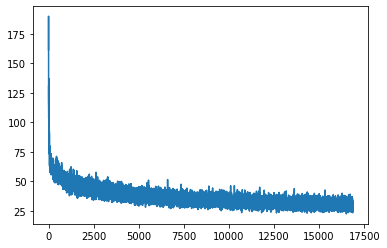

epoch: 10 	 step:0 	 loss: 30.14
epoch: 10 	 step:100 	 loss: 27.75
epoch: 10 	 step:200 	 loss: 29.91
epoch: 10 	 step:300 	 loss: 30.18
epoch: 10 	 step:400 	 loss: 27.67
epoch: 10 	 step:500 	 loss: 28.86
epoch: 10 	 step:600 	 loss: 33.25
epoch: 10 	 step:700 	 loss: 30.71
epoch: 10 	 step:800 	 loss: 32.61
epoch: 10 	 step:900 	 loss: 30.24
epoch: 10 	 step:1000 	 loss: 29.81
epoch: 10 	 step:1100 	 loss: 27.5
epoch: 10 	 step:1200 	 loss: 28.38
epoch: 10 	 step:1300 	 loss: 26.97
epoch: 10 	 step:1400 	 loss: 27.74
epoch: 10 	 step:1500 	 loss: 32.33
epoch: 10 	 step:1600 	 loss: 30.89
epoch: 10 	 step:1700 	 loss: 31.22
epoch: 10 	 step:1800 	 loss: 28.81


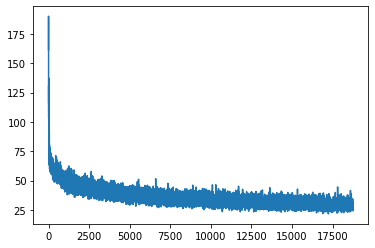

epoch: 11 	 step:0 	 loss: 29.8
epoch: 11 	 step:100 	 loss: 28.5
epoch: 11 	 step:200 	 loss: 31.07
epoch: 11 	 step:300 	 loss: 29.28
epoch: 11 	 step:400 	 loss: 25.97
epoch: 11 	 step:500 	 loss: 28.77
epoch: 11 	 step:600 	 loss: 30.81
epoch: 11 	 step:700 	 loss: 26.0
epoch: 11 	 step:800 	 loss: 27.26
epoch: 11 	 step:900 	 loss: 25.32
epoch: 11 	 step:1000 	 loss: 30.46
epoch: 11 	 step:1100 	 loss: 29.63
epoch: 11 	 step:1200 	 loss: 30.37
epoch: 11 	 step:1300 	 loss: 25.27
epoch: 11 	 step:1400 	 loss: 25.15
epoch: 11 	 step:1500 	 loss: 30.3
epoch: 11 	 step:1600 	 loss: 33.33
epoch: 11 	 step:1700 	 loss: 31.07
epoch: 11 	 step:1800 	 loss: 27.85


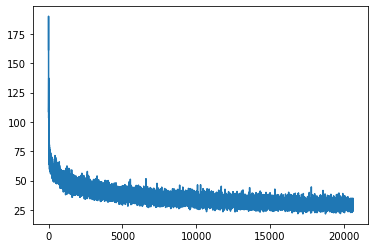

epoch: 12 	 step:0 	 loss: 26.54
epoch: 12 	 step:100 	 loss: 28.3
epoch: 12 	 step:200 	 loss: 27.7
epoch: 12 	 step:300 	 loss: 30.96
epoch: 12 	 step:400 	 loss: 31.42
epoch: 12 	 step:500 	 loss: 28.94
epoch: 12 	 step:600 	 loss: 24.94
epoch: 12 	 step:700 	 loss: 32.11
epoch: 12 	 step:800 	 loss: 28.65
epoch: 12 	 step:900 	 loss: 28.58
epoch: 12 	 step:1000 	 loss: 24.99
epoch: 12 	 step:1100 	 loss: 29.82
epoch: 12 	 step:1200 	 loss: 29.96
epoch: 12 	 step:1300 	 loss: 28.25
epoch: 12 	 step:1400 	 loss: 29.3
epoch: 12 	 step:1500 	 loss: 29.46
epoch: 12 	 step:1600 	 loss: 27.69
epoch: 12 	 step:1700 	 loss: 26.24
epoch: 12 	 step:1800 	 loss: 24.88


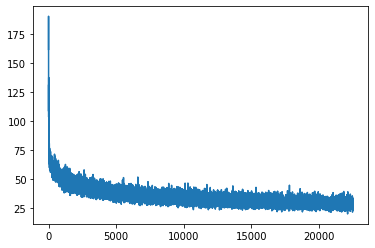

epoch: 13 	 step:0 	 loss: 29.96
epoch: 13 	 step:100 	 loss: 24.76
epoch: 13 	 step:200 	 loss: 23.67
epoch: 13 	 step:300 	 loss: 30.99
epoch: 13 	 step:400 	 loss: 27.61
epoch: 13 	 step:500 	 loss: 27.43
epoch: 13 	 step:600 	 loss: 28.91
epoch: 13 	 step:700 	 loss: 25.57
epoch: 13 	 step:800 	 loss: 29.77
epoch: 13 	 step:900 	 loss: 29.05
epoch: 13 	 step:1000 	 loss: 24.81
epoch: 13 	 step:1100 	 loss: 30.17
epoch: 13 	 step:1200 	 loss: 28.0
epoch: 13 	 step:1300 	 loss: 29.26
epoch: 13 	 step:1400 	 loss: 29.14
epoch: 13 	 step:1500 	 loss: 30.3
epoch: 13 	 step:1600 	 loss: 25.89
epoch: 13 	 step:1700 	 loss: 25.46
epoch: 13 	 step:1800 	 loss: 28.94


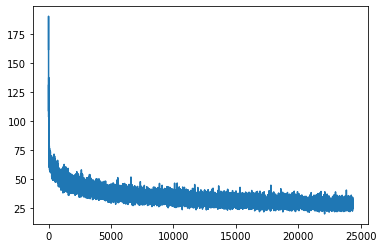

epoch: 14 	 step:0 	 loss: 23.94
epoch: 14 	 step:100 	 loss: 30.54
epoch: 14 	 step:200 	 loss: 27.7
epoch: 14 	 step:300 	 loss: 25.0
epoch: 14 	 step:400 	 loss: 28.4
epoch: 14 	 step:500 	 loss: 27.55
epoch: 14 	 step:600 	 loss: 25.72
epoch: 14 	 step:700 	 loss: 28.36
epoch: 14 	 step:800 	 loss: 27.95
epoch: 14 	 step:900 	 loss: 27.71
epoch: 14 	 step:1000 	 loss: 25.53
epoch: 14 	 step:1100 	 loss: 30.64
epoch: 14 	 step:1200 	 loss: 27.07
epoch: 14 	 step:1300 	 loss: 23.49
epoch: 14 	 step:1400 	 loss: 28.8
epoch: 14 	 step:1500 	 loss: 28.27
epoch: 14 	 step:1600 	 loss: 27.93
epoch: 14 	 step:1700 	 loss: 29.17
epoch: 14 	 step:1800 	 loss: 24.06


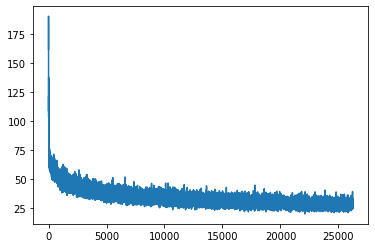

epoch: 15 	 step:0 	 loss: 24.87
epoch: 15 	 step:100 	 loss: 23.39
epoch: 15 	 step:200 	 loss: 21.67
epoch: 15 	 step:300 	 loss: 28.18
epoch: 15 	 step:400 	 loss: 26.84
epoch: 15 	 step:500 	 loss: 30.52
epoch: 15 	 step:600 	 loss: 25.85
epoch: 15 	 step:700 	 loss: 28.94
epoch: 15 	 step:800 	 loss: 27.03
epoch: 15 	 step:900 	 loss: 26.64
epoch: 15 	 step:1000 	 loss: 21.16
epoch: 15 	 step:1100 	 loss: 31.32
epoch: 15 	 step:1200 	 loss: 28.17
epoch: 15 	 step:1300 	 loss: 29.24
epoch: 15 	 step:1400 	 loss: 30.87
epoch: 15 	 step:1500 	 loss: 30.12
epoch: 15 	 step:1600 	 loss: 27.48
epoch: 15 	 step:1700 	 loss: 26.2
epoch: 15 	 step:1800 	 loss: 21.83


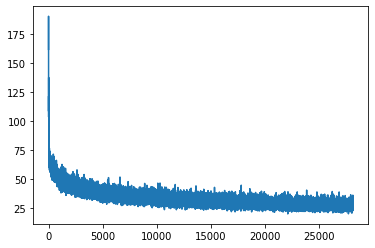

epoch: 16 	 step:0 	 loss: 28.75
epoch: 16 	 step:100 	 loss: 28.09
epoch: 16 	 step:200 	 loss: 23.25
epoch: 16 	 step:300 	 loss: 23.43
epoch: 16 	 step:400 	 loss: 24.97
epoch: 16 	 step:500 	 loss: 24.5
epoch: 16 	 step:600 	 loss: 30.86
epoch: 16 	 step:700 	 loss: 26.11
epoch: 16 	 step:800 	 loss: 27.17
epoch: 16 	 step:900 	 loss: 28.62
epoch: 16 	 step:1000 	 loss: 29.59
epoch: 16 	 step:1100 	 loss: 26.64
epoch: 16 	 step:1200 	 loss: 23.81
epoch: 16 	 step:1300 	 loss: 23.88
epoch: 16 	 step:1400 	 loss: 31.23
epoch: 16 	 step:1500 	 loss: 23.9
epoch: 16 	 step:1600 	 loss: 25.01
epoch: 16 	 step:1700 	 loss: 29.19
epoch: 16 	 step:1800 	 loss: 30.88


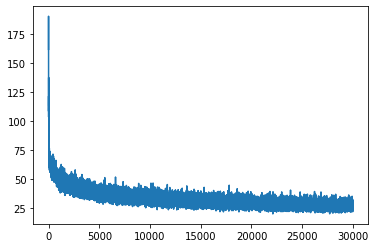

epoch: 17 	 step:0 	 loss: 24.83
epoch: 17 	 step:100 	 loss: 23.02
epoch: 17 	 step:200 	 loss: 24.25
epoch: 17 	 step:300 	 loss: 26.51
epoch: 17 	 step:400 	 loss: 28.26
epoch: 17 	 step:500 	 loss: 26.91
epoch: 17 	 step:600 	 loss: 23.9
epoch: 17 	 step:700 	 loss: 28.96
epoch: 17 	 step:800 	 loss: 29.44
epoch: 17 	 step:900 	 loss: 26.49
epoch: 17 	 step:1000 	 loss: 25.06
epoch: 17 	 step:1100 	 loss: 26.25
epoch: 17 	 step:1200 	 loss: 32.15
epoch: 17 	 step:1300 	 loss: 31.56
epoch: 17 	 step:1400 	 loss: 27.31
epoch: 17 	 step:1500 	 loss: 25.13
epoch: 17 	 step:1600 	 loss: 24.57
epoch: 17 	 step:1700 	 loss: 27.56
epoch: 17 	 step:1800 	 loss: 26.9


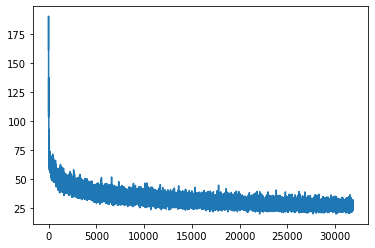

epoch: 18 	 step:0 	 loss: 25.66
epoch: 18 	 step:100 	 loss: 24.54
epoch: 18 	 step:200 	 loss: 23.55
epoch: 18 	 step:300 	 loss: 22.55
epoch: 18 	 step:400 	 loss: 25.84
epoch: 18 	 step:500 	 loss: 26.81
epoch: 18 	 step:600 	 loss: 26.93
epoch: 18 	 step:700 	 loss: 24.46
epoch: 18 	 step:800 	 loss: 22.87
epoch: 18 	 step:900 	 loss: 22.25
epoch: 18 	 step:1000 	 loss: 27.1
epoch: 18 	 step:1100 	 loss: 27.79
epoch: 18 	 step:1200 	 loss: 25.65
epoch: 18 	 step:1300 	 loss: 23.12
epoch: 18 	 step:1400 	 loss: 27.94
epoch: 18 	 step:1500 	 loss: 22.51
epoch: 18 	 step:1600 	 loss: 25.86
epoch: 18 	 step:1700 	 loss: 24.2
epoch: 18 	 step:1800 	 loss: 31.22


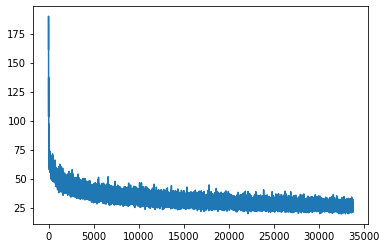

epoch: 19 	 step:0 	 loss: 26.13
epoch: 19 	 step:100 	 loss: 27.67
epoch: 19 	 step:200 	 loss: 23.23
epoch: 19 	 step:300 	 loss: 26.39
epoch: 19 	 step:400 	 loss: 25.54
epoch: 19 	 step:500 	 loss: 24.32
epoch: 19 	 step:600 	 loss: 26.01
epoch: 19 	 step:700 	 loss: 25.08
epoch: 19 	 step:800 	 loss: 24.18
epoch: 19 	 step:900 	 loss: 27.38
epoch: 19 	 step:1000 	 loss: 28.1
epoch: 19 	 step:1100 	 loss: 25.6
epoch: 19 	 step:1200 	 loss: 23.76
epoch: 19 	 step:1300 	 loss: 21.85
epoch: 19 	 step:1400 	 loss: 24.33
epoch: 19 	 step:1500 	 loss: 20.56
epoch: 19 	 step:1600 	 loss: 24.62
epoch: 19 	 step:1700 	 loss: 29.31
epoch: 19 	 step:1800 	 loss: 26.43


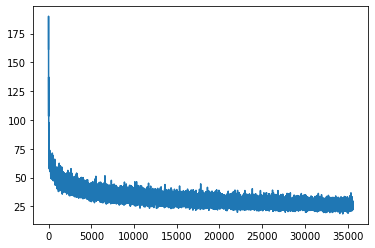

epoch: 20 	 step:0 	 loss: 28.07
epoch: 20 	 step:100 	 loss: 25.37
epoch: 20 	 step:200 	 loss: 23.87
epoch: 20 	 step:300 	 loss: 27.39
epoch: 20 	 step:400 	 loss: 23.48
epoch: 20 	 step:500 	 loss: 22.94
epoch: 20 	 step:600 	 loss: 25.01
epoch: 20 	 step:700 	 loss: 25.89
epoch: 20 	 step:800 	 loss: 26.06
epoch: 20 	 step:900 	 loss: 25.41
epoch: 20 	 step:1000 	 loss: 28.07
epoch: 20 	 step:1100 	 loss: 26.28
epoch: 20 	 step:1200 	 loss: 24.09
epoch: 20 	 step:1300 	 loss: 24.75
epoch: 20 	 step:1400 	 loss: 26.95
epoch: 20 	 step:1500 	 loss: 26.37
epoch: 20 	 step:1600 	 loss: 25.36
epoch: 20 	 step:1700 	 loss: 28.18
epoch: 20 	 step:1800 	 loss: 24.37


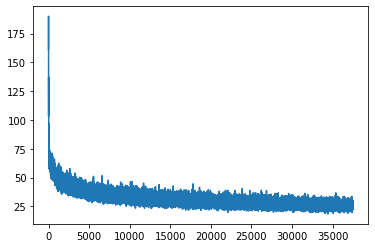

epoch: 21 	 step:0 	 loss: 30.5
epoch: 21 	 step:100 	 loss: 24.49
epoch: 21 	 step:200 	 loss: 22.56
epoch: 21 	 step:300 	 loss: 22.76
epoch: 21 	 step:400 	 loss: 31.91
epoch: 21 	 step:500 	 loss: 24.85
epoch: 21 	 step:600 	 loss: 25.83
epoch: 21 	 step:700 	 loss: 23.45
epoch: 21 	 step:800 	 loss: 24.99
epoch: 21 	 step:900 	 loss: 22.66
epoch: 21 	 step:1000 	 loss: 24.69
epoch: 21 	 step:1100 	 loss: 23.02
epoch: 21 	 step:1200 	 loss: 28.55
epoch: 21 	 step:1300 	 loss: 24.88
epoch: 21 	 step:1400 	 loss: 24.69
epoch: 21 	 step:1500 	 loss: 27.05
epoch: 21 	 step:1600 	 loss: 25.01
epoch: 21 	 step:1700 	 loss: 24.61
epoch: 21 	 step:1800 	 loss: 27.29


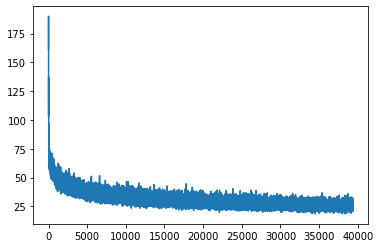

epoch: 22 	 step:0 	 loss: 22.48
epoch: 22 	 step:100 	 loss: 23.1
epoch: 22 	 step:200 	 loss: 26.49
epoch: 22 	 step:300 	 loss: 28.13
epoch: 22 	 step:400 	 loss: 23.4
epoch: 22 	 step:500 	 loss: 20.5
epoch: 22 	 step:600 	 loss: 27.43
epoch: 22 	 step:700 	 loss: 25.47
epoch: 22 	 step:800 	 loss: 23.62
epoch: 22 	 step:900 	 loss: 30.47
epoch: 22 	 step:1000 	 loss: 23.65
epoch: 22 	 step:1100 	 loss: 21.44
epoch: 22 	 step:1200 	 loss: 24.74
epoch: 22 	 step:1300 	 loss: 22.67
epoch: 22 	 step:1400 	 loss: 21.42
epoch: 22 	 step:1500 	 loss: 23.42
epoch: 22 	 step:1600 	 loss: 24.99
epoch: 22 	 step:1700 	 loss: 23.65
epoch: 22 	 step:1800 	 loss: 25.45


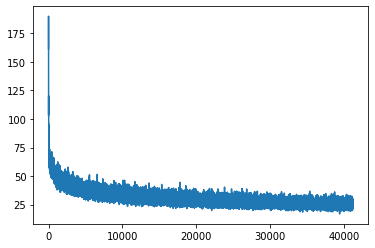

epoch: 23 	 step:0 	 loss: 23.26
epoch: 23 	 step:100 	 loss: 21.07
epoch: 23 	 step:200 	 loss: 23.2
epoch: 23 	 step:300 	 loss: 21.23
epoch: 23 	 step:400 	 loss: 25.38
epoch: 23 	 step:500 	 loss: 24.84
epoch: 23 	 step:600 	 loss: 24.99
epoch: 23 	 step:700 	 loss: 23.92
epoch: 23 	 step:800 	 loss: 27.25
epoch: 23 	 step:900 	 loss: 24.35
epoch: 23 	 step:1000 	 loss: 27.34
epoch: 23 	 step:1100 	 loss: 24.27
epoch: 23 	 step:1200 	 loss: 23.68
epoch: 23 	 step:1300 	 loss: 27.04
epoch: 23 	 step:1400 	 loss: 22.63
epoch: 23 	 step:1500 	 loss: 24.46
epoch: 23 	 step:1600 	 loss: 27.1
epoch: 23 	 step:1700 	 loss: 26.69
epoch: 23 	 step:1800 	 loss: 26.12


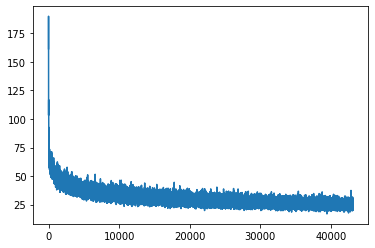

epoch: 24 	 step:0 	 loss: 25.17
epoch: 24 	 step:100 	 loss: 26.03
epoch: 24 	 step:200 	 loss: 21.24
epoch: 24 	 step:300 	 loss: 22.61
epoch: 24 	 step:400 	 loss: 23.2
epoch: 24 	 step:500 	 loss: 24.17
epoch: 24 	 step:600 	 loss: 26.23
epoch: 24 	 step:700 	 loss: 24.49
epoch: 24 	 step:800 	 loss: 23.25
epoch: 24 	 step:900 	 loss: 21.07
epoch: 24 	 step:1000 	 loss: 24.63
epoch: 24 	 step:1100 	 loss: 25.34
epoch: 24 	 step:1200 	 loss: 24.12
epoch: 24 	 step:1300 	 loss: 23.14
epoch: 24 	 step:1400 	 loss: 24.69
epoch: 24 	 step:1500 	 loss: 22.77
epoch: 24 	 step:1600 	 loss: 21.69
epoch: 24 	 step:1700 	 loss: 26.98
epoch: 24 	 step:1800 	 loss: 23.55


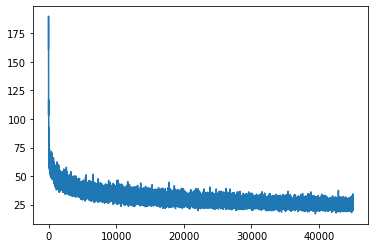

epoch: 25 	 step:0 	 loss: 25.05
epoch: 25 	 step:100 	 loss: 25.84
epoch: 25 	 step:200 	 loss: 20.84
epoch: 25 	 step:300 	 loss: 24.59
epoch: 25 	 step:400 	 loss: 24.55
epoch: 25 	 step:500 	 loss: 21.66
epoch: 25 	 step:600 	 loss: 23.86
epoch: 25 	 step:700 	 loss: 23.75
epoch: 25 	 step:800 	 loss: 25.22
epoch: 25 	 step:900 	 loss: 20.84
epoch: 25 	 step:1000 	 loss: 23.35
epoch: 25 	 step:1100 	 loss: 20.82
epoch: 25 	 step:1200 	 loss: 23.14
epoch: 25 	 step:1300 	 loss: 23.67
epoch: 25 	 step:1400 	 loss: 27.25
epoch: 25 	 step:1500 	 loss: 23.42
epoch: 25 	 step:1600 	 loss: 25.08
epoch: 25 	 step:1700 	 loss: 25.37
epoch: 25 	 step:1800 	 loss: 26.12


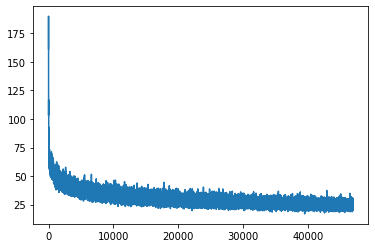

epoch: 26 	 step:0 	 loss: 21.68
epoch: 26 	 step:100 	 loss: 21.38
epoch: 26 	 step:200 	 loss: 23.64
epoch: 26 	 step:300 	 loss: 23.16
epoch: 26 	 step:400 	 loss: 23.7
epoch: 26 	 step:500 	 loss: 24.61
epoch: 26 	 step:600 	 loss: 29.23
epoch: 26 	 step:700 	 loss: 21.65
epoch: 26 	 step:800 	 loss: 25.89
epoch: 26 	 step:900 	 loss: 23.64
epoch: 26 	 step:1000 	 loss: 22.39
epoch: 26 	 step:1100 	 loss: 20.92
epoch: 26 	 step:1200 	 loss: 23.02
epoch: 26 	 step:1300 	 loss: 24.37
epoch: 26 	 step:1400 	 loss: 28.04
epoch: 26 	 step:1500 	 loss: 24.3
epoch: 26 	 step:1600 	 loss: 21.58
epoch: 26 	 step:1700 	 loss: 25.01
epoch: 26 	 step:1800 	 loss: 25.42


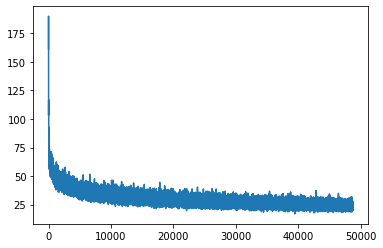

epoch: 27 	 step:0 	 loss: 24.11
epoch: 27 	 step:100 	 loss: 23.69
epoch: 27 	 step:200 	 loss: 25.44
epoch: 27 	 step:300 	 loss: 23.42
epoch: 27 	 step:400 	 loss: 20.1
epoch: 27 	 step:500 	 loss: 22.83
epoch: 27 	 step:600 	 loss: 21.03
epoch: 27 	 step:700 	 loss: 23.38
epoch: 27 	 step:800 	 loss: 25.58
epoch: 27 	 step:900 	 loss: 22.64
epoch: 27 	 step:1000 	 loss: 21.75
epoch: 27 	 step:1100 	 loss: 26.03
epoch: 27 	 step:1200 	 loss: 22.79
epoch: 27 	 step:1300 	 loss: 25.71
epoch: 27 	 step:1400 	 loss: 21.46
epoch: 27 	 step:1500 	 loss: 22.17
epoch: 27 	 step:1600 	 loss: 21.34
epoch: 27 	 step:1700 	 loss: 23.05
epoch: 27 	 step:1800 	 loss: 21.17


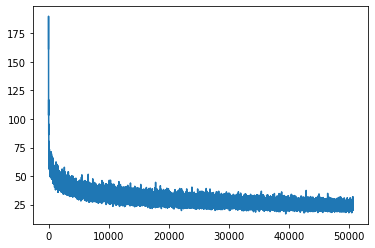

epoch: 28 	 step:0 	 loss: 23.3
epoch: 28 	 step:100 	 loss: 24.09
epoch: 28 	 step:200 	 loss: 22.8
epoch: 28 	 step:300 	 loss: 22.65
epoch: 28 	 step:400 	 loss: 22.67
epoch: 28 	 step:500 	 loss: 23.07
epoch: 28 	 step:600 	 loss: 21.46
epoch: 28 	 step:700 	 loss: 24.86
epoch: 28 	 step:800 	 loss: 23.05
epoch: 28 	 step:900 	 loss: 21.98
epoch: 28 	 step:1000 	 loss: 24.42
epoch: 28 	 step:1100 	 loss: 22.41
epoch: 28 	 step:1200 	 loss: 22.28
epoch: 28 	 step:1300 	 loss: 22.16
epoch: 28 	 step:1400 	 loss: 22.03
epoch: 28 	 step:1500 	 loss: 22.04
epoch: 28 	 step:1600 	 loss: 25.91
epoch: 28 	 step:1700 	 loss: 27.4
epoch: 28 	 step:1800 	 loss: 22.43


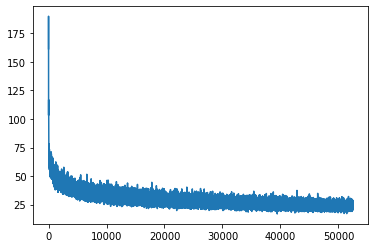

epoch: 29 	 step:0 	 loss: 23.61
epoch: 29 	 step:100 	 loss: 22.99
epoch: 29 	 step:200 	 loss: 23.24
epoch: 29 	 step:300 	 loss: 25.85
epoch: 29 	 step:400 	 loss: 21.93
epoch: 29 	 step:500 	 loss: 22.33
epoch: 29 	 step:600 	 loss: 24.33
epoch: 29 	 step:700 	 loss: 23.2
epoch: 29 	 step:800 	 loss: 24.47
epoch: 29 	 step:900 	 loss: 26.61
epoch: 29 	 step:1000 	 loss: 22.99
epoch: 29 	 step:1100 	 loss: 21.2
epoch: 29 	 step:1200 	 loss: 20.83
epoch: 29 	 step:1300 	 loss: 21.17
epoch: 29 	 step:1400 	 loss: 23.26
epoch: 29 	 step:1500 	 loss: 27.42
epoch: 29 	 step:1600 	 loss: 23.89
epoch: 29 	 step:1700 	 loss: 23.13
epoch: 29 	 step:1800 	 loss: 23.16


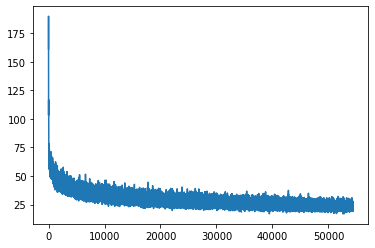

epoch: 30 	 step:0 	 loss: 22.53
epoch: 30 	 step:100 	 loss: 21.75
epoch: 30 	 step:200 	 loss: 25.18
epoch: 30 	 step:300 	 loss: 20.88
epoch: 30 	 step:400 	 loss: 21.93
epoch: 30 	 step:500 	 loss: 21.32
epoch: 30 	 step:600 	 loss: 22.89
epoch: 30 	 step:700 	 loss: 21.64
epoch: 30 	 step:800 	 loss: 22.07
epoch: 30 	 step:900 	 loss: 20.48
epoch: 30 	 step:1000 	 loss: 19.83
epoch: 30 	 step:1100 	 loss: 24.14
epoch: 30 	 step:1200 	 loss: 28.13
epoch: 30 	 step:1300 	 loss: 20.35
epoch: 30 	 step:1400 	 loss: 20.08
epoch: 30 	 step:1500 	 loss: 20.71
epoch: 30 	 step:1600 	 loss: 24.25
epoch: 30 	 step:1700 	 loss: 24.08
epoch: 30 	 step:1800 	 loss: 25.41


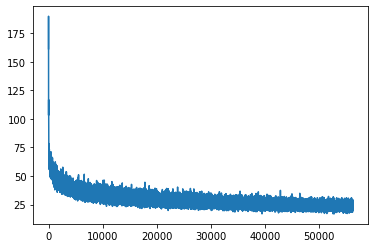

epoch: 31 	 step:0 	 loss: 19.77
epoch: 31 	 step:100 	 loss: 19.6
epoch: 31 	 step:200 	 loss: 24.59
epoch: 31 	 step:300 	 loss: 22.06
epoch: 31 	 step:400 	 loss: 22.47
epoch: 31 	 step:500 	 loss: 25.92
epoch: 31 	 step:600 	 loss: 23.72
epoch: 31 	 step:700 	 loss: 22.51
epoch: 31 	 step:800 	 loss: 21.54
epoch: 31 	 step:900 	 loss: 20.64
epoch: 31 	 step:1000 	 loss: 22.42
epoch: 31 	 step:1100 	 loss: 23.19
epoch: 31 	 step:1200 	 loss: 23.52
epoch: 31 	 step:1300 	 loss: 20.35
epoch: 31 	 step:1400 	 loss: 22.92
epoch: 31 	 step:1500 	 loss: 27.03
epoch: 31 	 step:1600 	 loss: 21.18
epoch: 31 	 step:1700 	 loss: 24.94
epoch: 31 	 step:1800 	 loss: 24.27


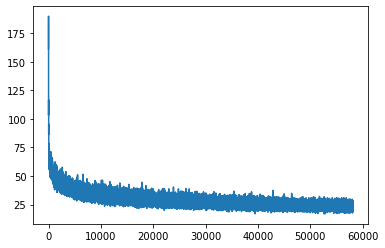

epoch: 32 	 step:0 	 loss: 23.01
epoch: 32 	 step:100 	 loss: 20.08
epoch: 32 	 step:200 	 loss: 24.61
epoch: 32 	 step:300 	 loss: 21.65
epoch: 32 	 step:400 	 loss: 24.58
epoch: 32 	 step:500 	 loss: 22.77
epoch: 32 	 step:600 	 loss: 23.75
epoch: 32 	 step:700 	 loss: 23.03
epoch: 32 	 step:800 	 loss: 23.97
epoch: 32 	 step:900 	 loss: 22.45
epoch: 32 	 step:1000 	 loss: 23.23
epoch: 32 	 step:1100 	 loss: 20.13
epoch: 32 	 step:1200 	 loss: 25.28
epoch: 32 	 step:1300 	 loss: 21.8
epoch: 32 	 step:1400 	 loss: 23.68
epoch: 32 	 step:1500 	 loss: 20.54
epoch: 32 	 step:1600 	 loss: 19.04
epoch: 32 	 step:1700 	 loss: 19.51
epoch: 32 	 step:1800 	 loss: 22.6


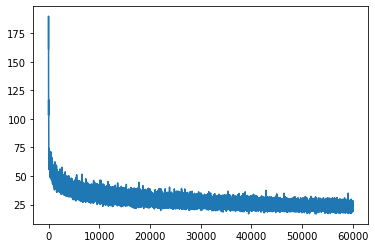

epoch: 33 	 step:0 	 loss: 23.89
epoch: 33 	 step:100 	 loss: 23.52
epoch: 33 	 step:200 	 loss: 21.3
epoch: 33 	 step:300 	 loss: 18.87
epoch: 33 	 step:400 	 loss: 23.88
epoch: 33 	 step:500 	 loss: 22.22
epoch: 33 	 step:600 	 loss: 23.71
epoch: 33 	 step:700 	 loss: 22.09
epoch: 33 	 step:800 	 loss: 24.77
epoch: 33 	 step:900 	 loss: 33.76
epoch: 33 	 step:1000 	 loss: 23.56
epoch: 33 	 step:1100 	 loss: 22.29
epoch: 33 	 step:1200 	 loss: 20.39
epoch: 33 	 step:1300 	 loss: 26.06
epoch: 33 	 step:1400 	 loss: 22.05
epoch: 33 	 step:1500 	 loss: 21.04
epoch: 33 	 step:1600 	 loss: 22.24
epoch: 33 	 step:1700 	 loss: 22.59
epoch: 33 	 step:1800 	 loss: 25.2


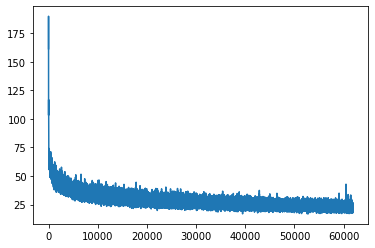

epoch: 34 	 step:0 	 loss: 23.22
epoch: 34 	 step:100 	 loss: 22.2
epoch: 34 	 step:200 	 loss: 27.09
epoch: 34 	 step:300 	 loss: 21.05
epoch: 34 	 step:400 	 loss: 20.25
epoch: 34 	 step:500 	 loss: 25.07
epoch: 34 	 step:600 	 loss: 19.85
epoch: 34 	 step:700 	 loss: 21.94
epoch: 34 	 step:800 	 loss: 20.65
epoch: 34 	 step:900 	 loss: 23.44
epoch: 34 	 step:1000 	 loss: 20.57
epoch: 34 	 step:1100 	 loss: 19.27
epoch: 34 	 step:1200 	 loss: 22.59
epoch: 34 	 step:1300 	 loss: 23.05
epoch: 34 	 step:1400 	 loss: 24.48
epoch: 34 	 step:1500 	 loss: 22.18
epoch: 34 	 step:1600 	 loss: 24.52
epoch: 34 	 step:1700 	 loss: 23.64
epoch: 34 	 step:1800 	 loss: 24.25


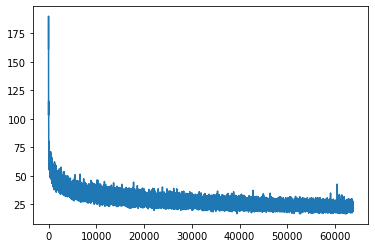

epoch: 35 	 step:0 	 loss: 21.54
epoch: 35 	 step:100 	 loss: 22.45
epoch: 35 	 step:200 	 loss: 20.01
epoch: 35 	 step:300 	 loss: 21.21
epoch: 35 	 step:400 	 loss: 21.16
epoch: 35 	 step:500 	 loss: 21.63
epoch: 35 	 step:600 	 loss: 19.9
epoch: 35 	 step:700 	 loss: 23.65
epoch: 35 	 step:800 	 loss: 23.52
epoch: 35 	 step:900 	 loss: 24.1
epoch: 35 	 step:1000 	 loss: 20.73
epoch: 35 	 step:1100 	 loss: 24.84
epoch: 35 	 step:1200 	 loss: 24.44
epoch: 35 	 step:1300 	 loss: 22.93
epoch: 35 	 step:1400 	 loss: 19.0
epoch: 35 	 step:1500 	 loss: 25.96
epoch: 35 	 step:1600 	 loss: 19.68
epoch: 35 	 step:1700 	 loss: 22.86
epoch: 35 	 step:1800 	 loss: 19.53


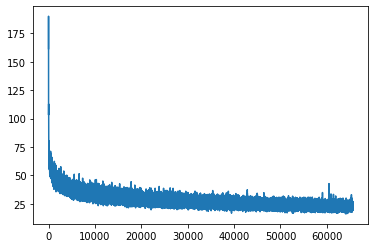

epoch: 36 	 step:0 	 loss: 24.6
epoch: 36 	 step:100 	 loss: 20.3
epoch: 36 	 step:200 	 loss: 21.55
epoch: 36 	 step:300 	 loss: 22.66
epoch: 36 	 step:400 	 loss: 23.58
epoch: 36 	 step:500 	 loss: 23.56
epoch: 36 	 step:600 	 loss: 21.18
epoch: 36 	 step:700 	 loss: 26.75
epoch: 36 	 step:800 	 loss: 20.04
epoch: 36 	 step:900 	 loss: 21.73
epoch: 36 	 step:1000 	 loss: 27.58
epoch: 36 	 step:1100 	 loss: 21.75
epoch: 36 	 step:1200 	 loss: 23.94
epoch: 36 	 step:1300 	 loss: 19.57
epoch: 36 	 step:1400 	 loss: 20.5
epoch: 36 	 step:1500 	 loss: 23.36
epoch: 36 	 step:1600 	 loss: 24.34
epoch: 36 	 step:1700 	 loss: 21.51
epoch: 36 	 step:1800 	 loss: 21.51


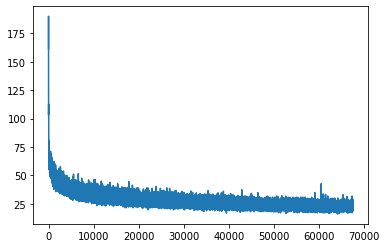

epoch: 37 	 step:0 	 loss: 20.12
epoch: 37 	 step:100 	 loss: 23.62
epoch: 37 	 step:200 	 loss: 22.12
epoch: 37 	 step:300 	 loss: 24.1
epoch: 37 	 step:400 	 loss: 22.42
epoch: 37 	 step:500 	 loss: 25.21
epoch: 37 	 step:600 	 loss: 18.98
epoch: 37 	 step:700 	 loss: 20.47
epoch: 37 	 step:800 	 loss: 19.5
epoch: 37 	 step:900 	 loss: 22.33
epoch: 37 	 step:1000 	 loss: 21.45
epoch: 37 	 step:1100 	 loss: 22.33
epoch: 37 	 step:1200 	 loss: 19.86
epoch: 37 	 step:1300 	 loss: 21.19
epoch: 37 	 step:1400 	 loss: 18.82
epoch: 37 	 step:1500 	 loss: 23.46
epoch: 37 	 step:1600 	 loss: 24.1
epoch: 37 	 step:1700 	 loss: 26.5
epoch: 37 	 step:1800 	 loss: 26.72


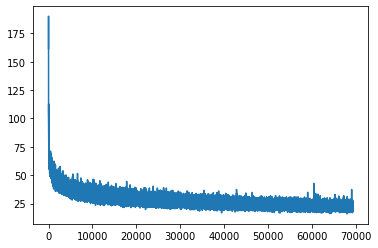

epoch: 38 	 step:0 	 loss: 21.91
epoch: 38 	 step:100 	 loss: 22.07
epoch: 38 	 step:200 	 loss: 20.71
epoch: 38 	 step:300 	 loss: 24.26
epoch: 38 	 step:400 	 loss: 24.35
epoch: 38 	 step:500 	 loss: 21.97
epoch: 38 	 step:600 	 loss: 21.97
epoch: 38 	 step:700 	 loss: 18.85
epoch: 38 	 step:800 	 loss: 21.11
epoch: 38 	 step:900 	 loss: 20.92
epoch: 38 	 step:1000 	 loss: 21.68
epoch: 38 	 step:1100 	 loss: 19.28
epoch: 38 	 step:1200 	 loss: 23.23
epoch: 38 	 step:1300 	 loss: 21.5
epoch: 38 	 step:1400 	 loss: 22.43
epoch: 38 	 step:1500 	 loss: 27.84
epoch: 38 	 step:1600 	 loss: 23.52
epoch: 38 	 step:1700 	 loss: 23.52
epoch: 38 	 step:1800 	 loss: 21.14


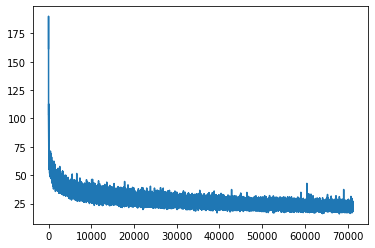

epoch: 39 	 step:0 	 loss: 23.81
epoch: 39 	 step:100 	 loss: 22.21
epoch: 39 	 step:200 	 loss: 21.87
epoch: 39 	 step:300 	 loss: 25.21
epoch: 39 	 step:400 	 loss: 20.86
epoch: 39 	 step:500 	 loss: 23.24
epoch: 39 	 step:600 	 loss: 18.94
epoch: 39 	 step:700 	 loss: 23.03
epoch: 39 	 step:800 	 loss: 24.28
epoch: 39 	 step:900 	 loss: 22.63
epoch: 39 	 step:1000 	 loss: 25.13
epoch: 39 	 step:1100 	 loss: 22.88
epoch: 39 	 step:1200 	 loss: 18.44
epoch: 39 	 step:1300 	 loss: 17.53
epoch: 39 	 step:1400 	 loss: 21.29
epoch: 39 	 step:1500 	 loss: 21.7
epoch: 39 	 step:1600 	 loss: 22.05
epoch: 39 	 step:1700 	 loss: 21.79
epoch: 39 	 step:1800 	 loss: 21.58


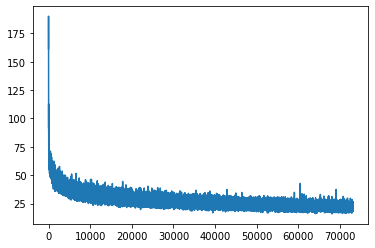

epoch: 40 	 step:0 	 loss: 18.25
epoch: 40 	 step:100 	 loss: 24.36
epoch: 40 	 step:200 	 loss: 20.24
epoch: 40 	 step:300 	 loss: 20.76
epoch: 40 	 step:400 	 loss: 21.8
epoch: 40 	 step:500 	 loss: 19.45
epoch: 40 	 step:600 	 loss: 18.87
epoch: 40 	 step:700 	 loss: 26.59
epoch: 40 	 step:800 	 loss: 20.84
epoch: 40 	 step:900 	 loss: 19.36
epoch: 40 	 step:1000 	 loss: 22.08
epoch: 40 	 step:1100 	 loss: 22.99
epoch: 40 	 step:1200 	 loss: 23.35
epoch: 40 	 step:1300 	 loss: 23.27
epoch: 40 	 step:1400 	 loss: 20.19
epoch: 40 	 step:1500 	 loss: 19.33
epoch: 40 	 step:1600 	 loss: 23.85
epoch: 40 	 step:1700 	 loss: 20.14
epoch: 40 	 step:1800 	 loss: 20.57


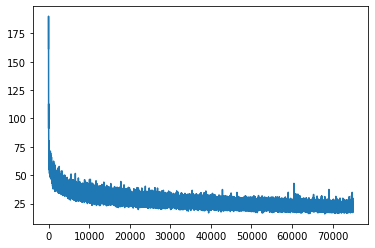

epoch: 41 	 step:0 	 loss: 20.2
epoch: 41 	 step:100 	 loss: 20.47
epoch: 41 	 step:200 	 loss: 20.46
epoch: 41 	 step:300 	 loss: 23.43
epoch: 41 	 step:400 	 loss: 20.26
epoch: 41 	 step:500 	 loss: 21.08
epoch: 41 	 step:600 	 loss: 21.69
epoch: 41 	 step:700 	 loss: 20.81
epoch: 41 	 step:800 	 loss: 20.2
epoch: 41 	 step:900 	 loss: 20.53
epoch: 41 	 step:1000 	 loss: 22.37
epoch: 41 	 step:1100 	 loss: 18.05
epoch: 41 	 step:1200 	 loss: 19.43
epoch: 41 	 step:1300 	 loss: 25.53
epoch: 41 	 step:1400 	 loss: 21.94
epoch: 41 	 step:1500 	 loss: 23.95
epoch: 41 	 step:1600 	 loss: 23.37
epoch: 41 	 step:1700 	 loss: 24.59
epoch: 41 	 step:1800 	 loss: 21.85


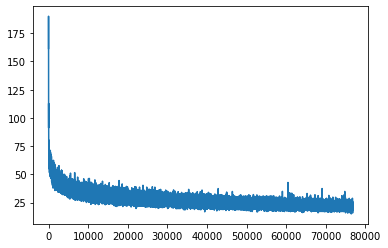

epoch: 42 	 step:0 	 loss: 25.56
epoch: 42 	 step:100 	 loss: 20.46
epoch: 42 	 step:200 	 loss: 18.63
epoch: 42 	 step:300 	 loss: 18.32
epoch: 42 	 step:400 	 loss: 19.65
epoch: 42 	 step:500 	 loss: 20.2
epoch: 42 	 step:600 	 loss: 25.17
epoch: 42 	 step:700 	 loss: 24.03
epoch: 42 	 step:800 	 loss: 19.63
epoch: 42 	 step:900 	 loss: 17.54
epoch: 42 	 step:1000 	 loss: 25.1
epoch: 42 	 step:1100 	 loss: 19.5
epoch: 42 	 step:1200 	 loss: 27.82
epoch: 42 	 step:1300 	 loss: 23.67
epoch: 42 	 step:1400 	 loss: 21.66
epoch: 42 	 step:1500 	 loss: 20.4
epoch: 42 	 step:1600 	 loss: 22.93
epoch: 42 	 step:1700 	 loss: 17.61
epoch: 42 	 step:1800 	 loss: 20.14


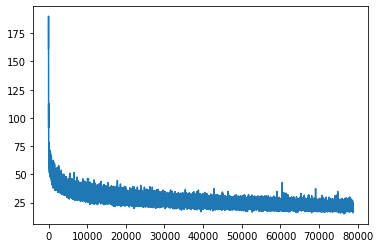

epoch: 43 	 step:0 	 loss: 18.43
epoch: 43 	 step:100 	 loss: 18.84
epoch: 43 	 step:200 	 loss: 21.29
epoch: 43 	 step:300 	 loss: 20.89
epoch: 43 	 step:400 	 loss: 24.97
epoch: 43 	 step:500 	 loss: 24.54
epoch: 43 	 step:600 	 loss: 23.36
epoch: 43 	 step:700 	 loss: 24.56
epoch: 43 	 step:800 	 loss: 20.64
epoch: 43 	 step:900 	 loss: 20.4
epoch: 43 	 step:1000 	 loss: 22.05
epoch: 43 	 step:1100 	 loss: 24.06
epoch: 43 	 step:1200 	 loss: 22.3
epoch: 43 	 step:1300 	 loss: 20.45
epoch: 43 	 step:1400 	 loss: 22.21
epoch: 43 	 step:1500 	 loss: 20.66
epoch: 43 	 step:1600 	 loss: 21.81
epoch: 43 	 step:1700 	 loss: 20.05
epoch: 43 	 step:1800 	 loss: 22.69


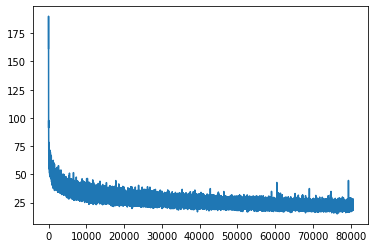

epoch: 44 	 step:0 	 loss: 22.79
epoch: 44 	 step:100 	 loss: 21.77
epoch: 44 	 step:200 	 loss: 20.13
epoch: 44 	 step:300 	 loss: 22.08
epoch: 44 	 step:400 	 loss: 18.32
epoch: 44 	 step:500 	 loss: 20.02
epoch: 44 	 step:600 	 loss: 20.56
epoch: 44 	 step:700 	 loss: 21.05
epoch: 44 	 step:800 	 loss: 23.17
epoch: 44 	 step:900 	 loss: 18.72
epoch: 44 	 step:1000 	 loss: 21.63
epoch: 44 	 step:1100 	 loss: 22.4
epoch: 44 	 step:1200 	 loss: 21.66
epoch: 44 	 step:1300 	 loss: 20.54
epoch: 44 	 step:1400 	 loss: 22.98
epoch: 44 	 step:1500 	 loss: 19.89
epoch: 44 	 step:1600 	 loss: 23.88
epoch: 44 	 step:1700 	 loss: 21.68
epoch: 44 	 step:1800 	 loss: 24.47


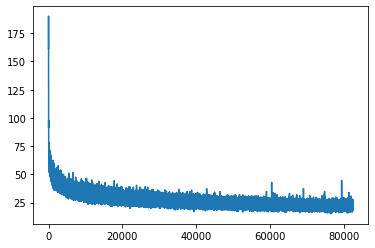

epoch: 45 	 step:0 	 loss: 22.71
epoch: 45 	 step:100 	 loss: 22.51
epoch: 45 	 step:200 	 loss: 20.66
epoch: 45 	 step:300 	 loss: 21.86
epoch: 45 	 step:400 	 loss: 21.85
epoch: 45 	 step:500 	 loss: 18.56
epoch: 45 	 step:600 	 loss: 20.46
epoch: 45 	 step:700 	 loss: 17.96
epoch: 45 	 step:800 	 loss: 20.75
epoch: 45 	 step:900 	 loss: 20.54
epoch: 45 	 step:1000 	 loss: 19.78
epoch: 45 	 step:1100 	 loss: 20.27
epoch: 45 	 step:1200 	 loss: 17.44
epoch: 45 	 step:1300 	 loss: 21.95
epoch: 45 	 step:1400 	 loss: 20.39
epoch: 45 	 step:1500 	 loss: 22.15
epoch: 45 	 step:1600 	 loss: 22.54
epoch: 45 	 step:1700 	 loss: 23.29
epoch: 45 	 step:1800 	 loss: 18.78


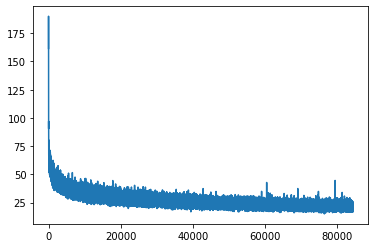

epoch: 46 	 step:0 	 loss: 21.61
epoch: 46 	 step:100 	 loss: 19.38
epoch: 46 	 step:200 	 loss: 21.68
epoch: 46 	 step:300 	 loss: 18.1
epoch: 46 	 step:400 	 loss: 20.68
epoch: 46 	 step:500 	 loss: 22.04
epoch: 46 	 step:600 	 loss: 18.19
epoch: 46 	 step:700 	 loss: 19.74
epoch: 46 	 step:800 	 loss: 19.33
epoch: 46 	 step:900 	 loss: 20.59
epoch: 46 	 step:1000 	 loss: 22.53
epoch: 46 	 step:1100 	 loss: 22.05
epoch: 46 	 step:1200 	 loss: 19.06
epoch: 46 	 step:1300 	 loss: 22.12
epoch: 46 	 step:1400 	 loss: 19.06
epoch: 46 	 step:1500 	 loss: 19.55
epoch: 46 	 step:1600 	 loss: 21.51
epoch: 46 	 step:1700 	 loss: 17.5
epoch: 46 	 step:1800 	 loss: 20.57


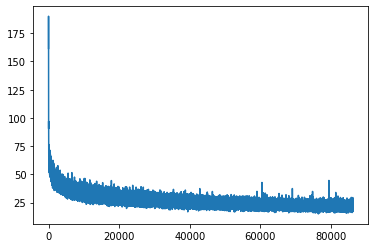

epoch: 47 	 step:0 	 loss: 24.35
epoch: 47 	 step:100 	 loss: 19.23
epoch: 47 	 step:200 	 loss: 19.49
epoch: 47 	 step:300 	 loss: 22.55
epoch: 47 	 step:400 	 loss: 21.28
epoch: 47 	 step:500 	 loss: 20.44
epoch: 47 	 step:600 	 loss: 18.55
epoch: 47 	 step:700 	 loss: 18.6
epoch: 47 	 step:800 	 loss: 21.14
epoch: 47 	 step:900 	 loss: 19.71
epoch: 47 	 step:1000 	 loss: 20.58
epoch: 47 	 step:1100 	 loss: 18.53
epoch: 47 	 step:1200 	 loss: 20.44
epoch: 47 	 step:1300 	 loss: 17.6
epoch: 47 	 step:1400 	 loss: 19.38
epoch: 47 	 step:1500 	 loss: 21.49
epoch: 47 	 step:1600 	 loss: 20.2
epoch: 47 	 step:1700 	 loss: 21.06
epoch: 47 	 step:1800 	 loss: 19.6


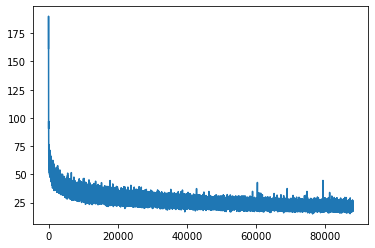

epoch: 48 	 step:0 	 loss: 20.05
epoch: 48 	 step:100 	 loss: 22.89
epoch: 48 	 step:200 	 loss: 24.16
epoch: 48 	 step:300 	 loss: 19.62
epoch: 48 	 step:400 	 loss: 19.91
epoch: 48 	 step:500 	 loss: 17.91
epoch: 48 	 step:600 	 loss: 19.2
epoch: 48 	 step:700 	 loss: 19.75
epoch: 48 	 step:800 	 loss: 21.79
epoch: 48 	 step:900 	 loss: 18.3
epoch: 48 	 step:1000 	 loss: 17.82
epoch: 48 	 step:1100 	 loss: 19.6
epoch: 48 	 step:1200 	 loss: 22.36
epoch: 48 	 step:1300 	 loss: 18.61
epoch: 48 	 step:1400 	 loss: 19.44
epoch: 48 	 step:1500 	 loss: 19.2
epoch: 48 	 step:1600 	 loss: 18.89
epoch: 48 	 step:1700 	 loss: 20.19
epoch: 48 	 step:1800 	 loss: 20.98


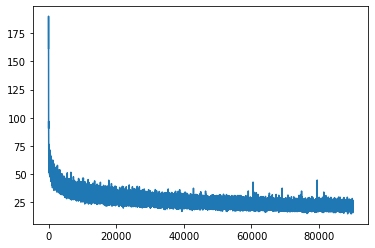

epoch: 49 	 step:0 	 loss: 18.39
epoch: 49 	 step:100 	 loss: 19.35
epoch: 49 	 step:200 	 loss: 20.14
epoch: 49 	 step:300 	 loss: 22.03
epoch: 49 	 step:400 	 loss: 23.75
epoch: 49 	 step:500 	 loss: 20.54
epoch: 49 	 step:600 	 loss: 22.75
epoch: 49 	 step:700 	 loss: 22.7
epoch: 49 	 step:800 	 loss: 20.89
epoch: 49 	 step:900 	 loss: 20.91
epoch: 49 	 step:1000 	 loss: 20.02
epoch: 49 	 step:1100 	 loss: 21.96
epoch: 49 	 step:1200 	 loss: 21.61
epoch: 49 	 step:1300 	 loss: 20.85
epoch: 49 	 step:1400 	 loss: 20.67
epoch: 49 	 step:1500 	 loss: 19.74
epoch: 49 	 step:1600 	 loss: 20.01
epoch: 49 	 step:1700 	 loss: 20.92
epoch: 49 	 step:1800 	 loss: 26.92


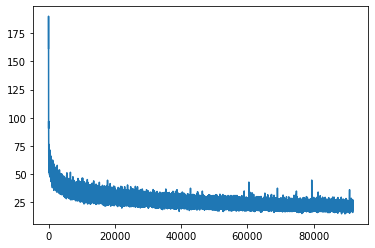

epoch: 50 	 step:0 	 loss: 22.25
epoch: 50 	 step:100 	 loss: 22.12
epoch: 50 	 step:200 	 loss: 20.34
epoch: 50 	 step:300 	 loss: 20.71
epoch: 50 	 step:400 	 loss: 18.55
epoch: 50 	 step:500 	 loss: 18.62
epoch: 50 	 step:600 	 loss: 19.79
epoch: 50 	 step:700 	 loss: 22.16
epoch: 50 	 step:800 	 loss: 20.86
epoch: 50 	 step:900 	 loss: 20.31
epoch: 50 	 step:1000 	 loss: 21.51
epoch: 50 	 step:1100 	 loss: 23.45
epoch: 50 	 step:1200 	 loss: 19.2
epoch: 50 	 step:1300 	 loss: 22.2
epoch: 50 	 step:1400 	 loss: 20.79
epoch: 50 	 step:1500 	 loss: 19.07
epoch: 50 	 step:1600 	 loss: 20.41
epoch: 50 	 step:1700 	 loss: 19.98
epoch: 50 	 step:1800 	 loss: 17.16


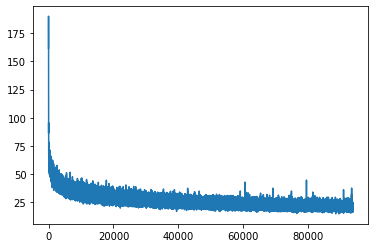

epoch: 51 	 step:0 	 loss: 17.56
epoch: 51 	 step:100 	 loss: 17.02
epoch: 51 	 step:200 	 loss: 22.77
epoch: 51 	 step:300 	 loss: 16.99
epoch: 51 	 step:400 	 loss: 20.74
epoch: 51 	 step:500 	 loss: 19.16
epoch: 51 	 step:600 	 loss: 20.94
epoch: 51 	 step:700 	 loss: 21.13
epoch: 51 	 step:800 	 loss: 22.15
epoch: 51 	 step:900 	 loss: 21.62
epoch: 51 	 step:1000 	 loss: 20.25
epoch: 51 	 step:1100 	 loss: 18.35
epoch: 51 	 step:1200 	 loss: 18.75
epoch: 51 	 step:1300 	 loss: 20.52
epoch: 51 	 step:1400 	 loss: 19.62
epoch: 51 	 step:1500 	 loss: 21.04
epoch: 51 	 step:1600 	 loss: 19.03
epoch: 51 	 step:1700 	 loss: 18.2
epoch: 51 	 step:1800 	 loss: 21.56


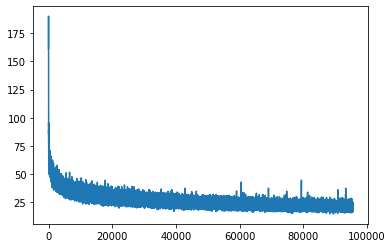

epoch: 52 	 step:0 	 loss: 18.62
epoch: 52 	 step:100 	 loss: 19.18
epoch: 52 	 step:200 	 loss: 19.86
epoch: 52 	 step:300 	 loss: 23.66
epoch: 52 	 step:400 	 loss: 18.14
epoch: 52 	 step:500 	 loss: 19.09
epoch: 52 	 step:600 	 loss: 20.12
epoch: 52 	 step:700 	 loss: 19.19
epoch: 52 	 step:800 	 loss: 19.1
epoch: 52 	 step:900 	 loss: 23.72
epoch: 52 	 step:1000 	 loss: 23.47
epoch: 52 	 step:1100 	 loss: 25.28
epoch: 52 	 step:1200 	 loss: 23.93
epoch: 52 	 step:1300 	 loss: 20.01
epoch: 52 	 step:1400 	 loss: 20.05
epoch: 52 	 step:1500 	 loss: 19.05
epoch: 52 	 step:1600 	 loss: 17.87
epoch: 52 	 step:1700 	 loss: 19.26
epoch: 52 	 step:1800 	 loss: 21.8


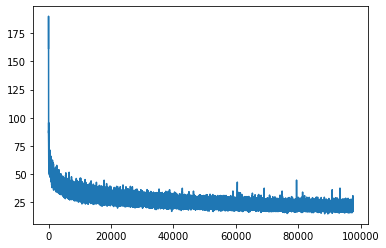

epoch: 53 	 step:0 	 loss: 19.08
epoch: 53 	 step:100 	 loss: 19.06
epoch: 53 	 step:200 	 loss: 22.2
epoch: 53 	 step:300 	 loss: 23.5
epoch: 53 	 step:400 	 loss: 17.05
epoch: 53 	 step:500 	 loss: 21.51
epoch: 53 	 step:600 	 loss: 20.46
epoch: 53 	 step:700 	 loss: 19.12
epoch: 53 	 step:800 	 loss: 18.93
epoch: 53 	 step:900 	 loss: 19.94
epoch: 53 	 step:1000 	 loss: 19.57
epoch: 53 	 step:1100 	 loss: 18.95
epoch: 53 	 step:1200 	 loss: 23.14
epoch: 53 	 step:1300 	 loss: 20.16
epoch: 53 	 step:1400 	 loss: 18.34
epoch: 53 	 step:1500 	 loss: 21.14
epoch: 53 	 step:1600 	 loss: 19.93
epoch: 53 	 step:1700 	 loss: 24.7
epoch: 53 	 step:1800 	 loss: 22.07


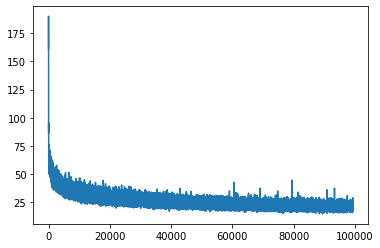

epoch: 54 	 step:0 	 loss: 17.29
epoch: 54 	 step:100 	 loss: 19.12
epoch: 54 	 step:200 	 loss: 21.11
epoch: 54 	 step:300 	 loss: 20.99
epoch: 54 	 step:400 	 loss: 20.49
epoch: 54 	 step:500 	 loss: 23.72
epoch: 54 	 step:600 	 loss: 20.99
epoch: 54 	 step:700 	 loss: 21.05
epoch: 54 	 step:800 	 loss: 20.72
epoch: 54 	 step:900 	 loss: 20.76
epoch: 54 	 step:1000 	 loss: 17.61
epoch: 54 	 step:1100 	 loss: 19.96
epoch: 54 	 step:1200 	 loss: 21.56
epoch: 54 	 step:1300 	 loss: 17.97
epoch: 54 	 step:1400 	 loss: 23.27
epoch: 54 	 step:1500 	 loss: 20.59
epoch: 54 	 step:1600 	 loss: 17.91
epoch: 54 	 step:1700 	 loss: 23.92
epoch: 54 	 step:1800 	 loss: 22.4


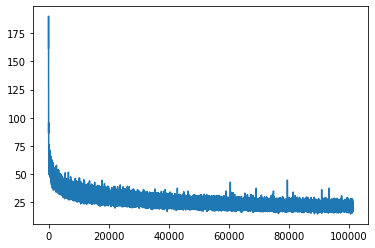

epoch: 55 	 step:0 	 loss: 16.62
epoch: 55 	 step:100 	 loss: 21.4
epoch: 55 	 step:200 	 loss: 20.54
epoch: 55 	 step:300 	 loss: 21.75
epoch: 55 	 step:400 	 loss: 19.9
epoch: 55 	 step:500 	 loss: 23.25
epoch: 55 	 step:600 	 loss: 20.17
epoch: 55 	 step:700 	 loss: 19.62
epoch: 55 	 step:800 	 loss: 20.58
epoch: 55 	 step:900 	 loss: 23.82
epoch: 55 	 step:1000 	 loss: 21.11
epoch: 55 	 step:1100 	 loss: 18.53
epoch: 55 	 step:1200 	 loss: 18.53
epoch: 55 	 step:1300 	 loss: 22.85
epoch: 55 	 step:1400 	 loss: 17.33
epoch: 55 	 step:1500 	 loss: 21.37
epoch: 55 	 step:1600 	 loss: 20.48
epoch: 55 	 step:1700 	 loss: 21.74
epoch: 55 	 step:1800 	 loss: 20.5


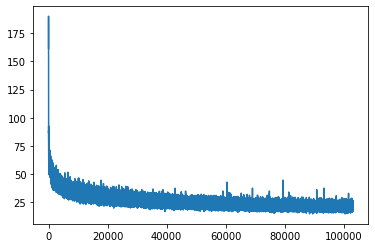

epoch: 56 	 step:0 	 loss: 19.55
epoch: 56 	 step:100 	 loss: 21.17
epoch: 56 	 step:200 	 loss: 25.06
epoch: 56 	 step:300 	 loss: 21.27
epoch: 56 	 step:400 	 loss: 26.11
epoch: 56 	 step:500 	 loss: 20.19
epoch: 56 	 step:600 	 loss: 21.93
epoch: 56 	 step:700 	 loss: 21.24
epoch: 56 	 step:800 	 loss: 20.1
epoch: 56 	 step:900 	 loss: 24.68
epoch: 56 	 step:1000 	 loss: 19.44
epoch: 56 	 step:1100 	 loss: 24.12
epoch: 56 	 step:1200 	 loss: 20.36
epoch: 56 	 step:1300 	 loss: 19.38
epoch: 56 	 step:1400 	 loss: 23.09
epoch: 56 	 step:1500 	 loss: 21.75
epoch: 56 	 step:1600 	 loss: 16.51
epoch: 56 	 step:1700 	 loss: 21.88
epoch: 56 	 step:1800 	 loss: 20.75


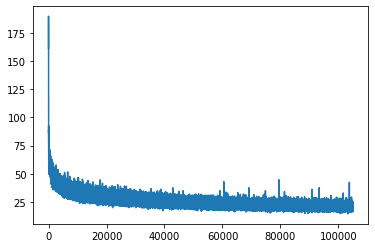

epoch: 57 	 step:0 	 loss: 18.55
epoch: 57 	 step:100 	 loss: 20.81
epoch: 57 	 step:200 	 loss: 19.23
epoch: 57 	 step:300 	 loss: 20.13
epoch: 57 	 step:400 	 loss: 19.06
epoch: 57 	 step:500 	 loss: 23.04
epoch: 57 	 step:600 	 loss: 21.58
epoch: 57 	 step:700 	 loss: 17.44
epoch: 57 	 step:800 	 loss: 19.23
epoch: 57 	 step:900 	 loss: 19.22
epoch: 57 	 step:1000 	 loss: 18.13
epoch: 57 	 step:1100 	 loss: 19.43
epoch: 57 	 step:1200 	 loss: 21.05
epoch: 57 	 step:1300 	 loss: 21.55
epoch: 57 	 step:1400 	 loss: 21.89
epoch: 57 	 step:1500 	 loss: 18.86
epoch: 57 	 step:1600 	 loss: 20.87
epoch: 57 	 step:1700 	 loss: 18.58
epoch: 57 	 step:1800 	 loss: 19.36


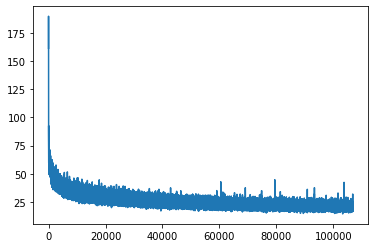

epoch: 58 	 step:0 	 loss: 20.7
epoch: 58 	 step:100 	 loss: 19.55
epoch: 58 	 step:200 	 loss: 21.69
epoch: 58 	 step:300 	 loss: 16.97
epoch: 58 	 step:400 	 loss: 21.09
epoch: 58 	 step:500 	 loss: 19.85
epoch: 58 	 step:600 	 loss: 17.87
epoch: 58 	 step:700 	 loss: 19.22
epoch: 58 	 step:800 	 loss: 19.88
epoch: 58 	 step:900 	 loss: 20.83
epoch: 58 	 step:1000 	 loss: 22.8
epoch: 58 	 step:1100 	 loss: 20.8
epoch: 58 	 step:1200 	 loss: 18.43
epoch: 58 	 step:1300 	 loss: 20.33
epoch: 58 	 step:1400 	 loss: 18.06
epoch: 58 	 step:1500 	 loss: 19.99
epoch: 58 	 step:1600 	 loss: 20.99
epoch: 58 	 step:1700 	 loss: 21.65
epoch: 58 	 step:1800 	 loss: 18.9


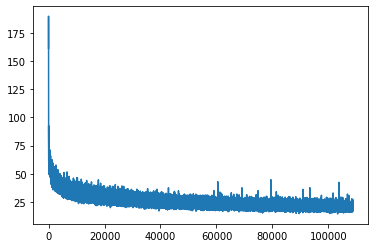

epoch: 59 	 step:0 	 loss: 20.6
epoch: 59 	 step:100 	 loss: 16.52
epoch: 59 	 step:200 	 loss: 18.79
epoch: 59 	 step:300 	 loss: 18.92
epoch: 59 	 step:400 	 loss: 19.87
epoch: 59 	 step:500 	 loss: 24.46
epoch: 59 	 step:600 	 loss: 16.79
epoch: 59 	 step:700 	 loss: 21.0
epoch: 59 	 step:800 	 loss: 17.22
epoch: 59 	 step:900 	 loss: 16.98
epoch: 59 	 step:1000 	 loss: 20.17
epoch: 59 	 step:1100 	 loss: 22.31
epoch: 59 	 step:1200 	 loss: 17.63
epoch: 59 	 step:1300 	 loss: 20.72
epoch: 59 	 step:1400 	 loss: 20.79
epoch: 59 	 step:1500 	 loss: 19.59
epoch: 59 	 step:1600 	 loss: 18.02
epoch: 59 	 step:1700 	 loss: 20.28
epoch: 59 	 step:1800 	 loss: 21.88


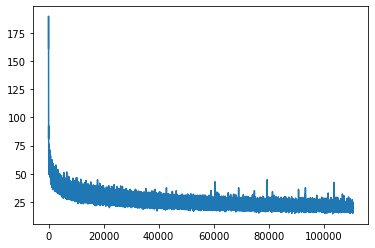

epoch: 60 	 step:0 	 loss: 19.43
epoch: 60 	 step:100 	 loss: 20.05
epoch: 60 	 step:200 	 loss: 20.97
epoch: 60 	 step:300 	 loss: 17.66
epoch: 60 	 step:400 	 loss: 18.43
epoch: 60 	 step:500 	 loss: 21.52
epoch: 60 	 step:600 	 loss: 18.73
epoch: 60 	 step:700 	 loss: 20.8
epoch: 60 	 step:800 	 loss: 23.37
epoch: 60 	 step:900 	 loss: 20.89
epoch: 60 	 step:1000 	 loss: 19.97
epoch: 60 	 step:1100 	 loss: 18.21
epoch: 60 	 step:1200 	 loss: 22.44
epoch: 60 	 step:1300 	 loss: 20.33
epoch: 60 	 step:1400 	 loss: 19.36
epoch: 60 	 step:1500 	 loss: 21.97
epoch: 60 	 step:1600 	 loss: 18.99
epoch: 60 	 step:1700 	 loss: 21.9
epoch: 60 	 step:1800 	 loss: 20.3


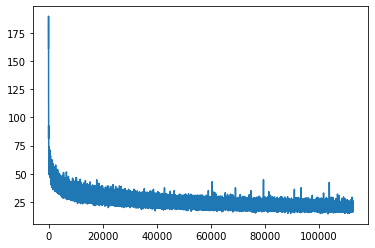

epoch: 61 	 step:0 	 loss: 19.67
epoch: 61 	 step:100 	 loss: 20.91
epoch: 61 	 step:200 	 loss: 18.87
epoch: 61 	 step:300 	 loss: 21.61
epoch: 61 	 step:400 	 loss: 19.96
epoch: 61 	 step:500 	 loss: 17.94
epoch: 61 	 step:600 	 loss: 19.79
epoch: 61 	 step:700 	 loss: 19.05
epoch: 61 	 step:800 	 loss: 19.01
epoch: 61 	 step:900 	 loss: 21.32
epoch: 61 	 step:1000 	 loss: 22.18
epoch: 61 	 step:1100 	 loss: 18.59
epoch: 61 	 step:1200 	 loss: 19.37
epoch: 61 	 step:1300 	 loss: 21.89
epoch: 61 	 step:1400 	 loss: 18.91
epoch: 61 	 step:1500 	 loss: 21.37
epoch: 61 	 step:1600 	 loss: 19.52
epoch: 61 	 step:1700 	 loss: 20.04
epoch: 61 	 step:1800 	 loss: 21.01


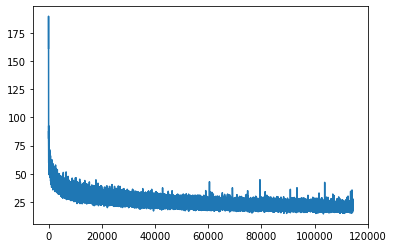

epoch: 62 	 step:0 	 loss: 20.06
epoch: 62 	 step:100 	 loss: 18.95
epoch: 62 	 step:200 	 loss: 21.64
epoch: 62 	 step:300 	 loss: 24.15
epoch: 62 	 step:400 	 loss: 22.58
epoch: 62 	 step:500 	 loss: 19.6
epoch: 62 	 step:600 	 loss: 19.46
epoch: 62 	 step:700 	 loss: 17.05
epoch: 62 	 step:800 	 loss: 21.74
epoch: 62 	 step:900 	 loss: 17.15
epoch: 62 	 step:1000 	 loss: 17.2
epoch: 62 	 step:1100 	 loss: 18.86
epoch: 62 	 step:1200 	 loss: 16.57
epoch: 62 	 step:1300 	 loss: 20.75
epoch: 62 	 step:1400 	 loss: 17.2
epoch: 62 	 step:1500 	 loss: 19.79
epoch: 62 	 step:1600 	 loss: 18.95
epoch: 62 	 step:1700 	 loss: 20.03
epoch: 62 	 step:1800 	 loss: 18.71


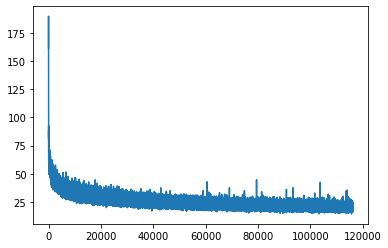

epoch: 63 	 step:0 	 loss: 21.12
epoch: 63 	 step:100 	 loss: 19.57
epoch: 63 	 step:200 	 loss: 18.81
epoch: 63 	 step:300 	 loss: 19.32
epoch: 63 	 step:400 	 loss: 17.89
epoch: 63 	 step:500 	 loss: 16.74
epoch: 63 	 step:600 	 loss: 21.01
epoch: 63 	 step:700 	 loss: 20.28
epoch: 63 	 step:800 	 loss: 19.13
epoch: 63 	 step:900 	 loss: 18.77
epoch: 63 	 step:1000 	 loss: 20.35
epoch: 63 	 step:1100 	 loss: 20.99
epoch: 63 	 step:1200 	 loss: 19.28
epoch: 63 	 step:1300 	 loss: 20.98
epoch: 63 	 step:1400 	 loss: 22.32
epoch: 63 	 step:1500 	 loss: 21.21
epoch: 63 	 step:1600 	 loss: 22.02
epoch: 63 	 step:1700 	 loss: 20.93
epoch: 63 	 step:1800 	 loss: 22.86


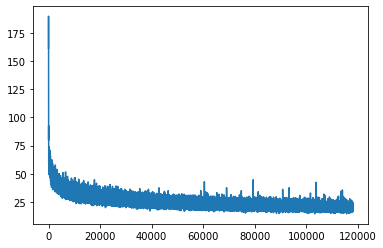

epoch: 64 	 step:0 	 loss: 20.26
epoch: 64 	 step:100 	 loss: 18.61
epoch: 64 	 step:200 	 loss: 20.35
epoch: 64 	 step:300 	 loss: 20.42
epoch: 64 	 step:400 	 loss: 19.58
epoch: 64 	 step:500 	 loss: 20.75
epoch: 64 	 step:600 	 loss: 22.07
epoch: 64 	 step:700 	 loss: 17.24
epoch: 64 	 step:800 	 loss: 22.35
epoch: 64 	 step:900 	 loss: 18.75
epoch: 64 	 step:1000 	 loss: 19.21
epoch: 64 	 step:1100 	 loss: 21.68
epoch: 64 	 step:1200 	 loss: 18.3
epoch: 64 	 step:1300 	 loss: 19.46
epoch: 64 	 step:1400 	 loss: 19.37
epoch: 64 	 step:1500 	 loss: 18.46
epoch: 64 	 step:1600 	 loss: 18.26
epoch: 64 	 step:1700 	 loss: 19.11
epoch: 64 	 step:1800 	 loss: 16.48


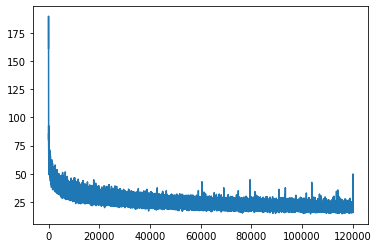

epoch: 65 	 step:0 	 loss: 19.68
epoch: 65 	 step:100 	 loss: 21.91
epoch: 65 	 step:200 	 loss: 22.86
epoch: 65 	 step:300 	 loss: 20.25
epoch: 65 	 step:400 	 loss: 20.76
epoch: 65 	 step:500 	 loss: 17.82
epoch: 65 	 step:600 	 loss: 19.79
epoch: 65 	 step:700 	 loss: 20.43
epoch: 65 	 step:800 	 loss: 22.1
epoch: 65 	 step:900 	 loss: 18.31
epoch: 65 	 step:1000 	 loss: 18.34
epoch: 65 	 step:1100 	 loss: 18.84
epoch: 65 	 step:1200 	 loss: 18.17
epoch: 65 	 step:1300 	 loss: 16.63
epoch: 65 	 step:1400 	 loss: 21.65
epoch: 65 	 step:1500 	 loss: 19.28
epoch: 65 	 step:1600 	 loss: 16.83
epoch: 65 	 step:1700 	 loss: 19.67
epoch: 65 	 step:1800 	 loss: 20.12


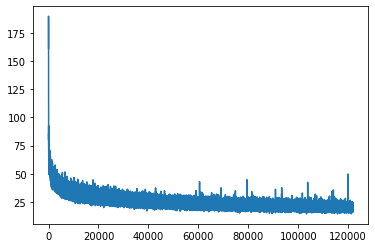

epoch: 66 	 step:0 	 loss: 19.27
epoch: 66 	 step:100 	 loss: 19.9
epoch: 66 	 step:200 	 loss: 20.47
epoch: 66 	 step:300 	 loss: 17.5
epoch: 66 	 step:400 	 loss: 17.23
epoch: 66 	 step:500 	 loss: 16.44
epoch: 66 	 step:600 	 loss: 19.76
epoch: 66 	 step:700 	 loss: 19.48
epoch: 66 	 step:800 	 loss: 19.27
epoch: 66 	 step:900 	 loss: 20.45
epoch: 66 	 step:1000 	 loss: 20.33
epoch: 66 	 step:1100 	 loss: 17.52
epoch: 66 	 step:1200 	 loss: 23.06
epoch: 66 	 step:1300 	 loss: 22.2
epoch: 66 	 step:1400 	 loss: 17.49
epoch: 66 	 step:1500 	 loss: 21.81
epoch: 66 	 step:1600 	 loss: 21.06
epoch: 66 	 step:1700 	 loss: 20.67
epoch: 66 	 step:1800 	 loss: 19.72


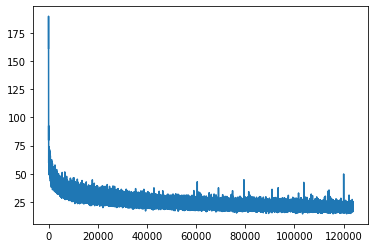

epoch: 67 	 step:0 	 loss: 20.21
epoch: 67 	 step:100 	 loss: 21.76
epoch: 67 	 step:200 	 loss: 19.15
epoch: 67 	 step:300 	 loss: 18.63
epoch: 67 	 step:400 	 loss: 17.3
epoch: 67 	 step:500 	 loss: 19.41
epoch: 67 	 step:600 	 loss: 19.47
epoch: 67 	 step:700 	 loss: 22.08
epoch: 67 	 step:800 	 loss: 17.55
epoch: 67 	 step:900 	 loss: 19.05
epoch: 67 	 step:1000 	 loss: 21.77
epoch: 67 	 step:1100 	 loss: 19.96
epoch: 67 	 step:1200 	 loss: 19.79
epoch: 67 	 step:1300 	 loss: 19.22
epoch: 67 	 step:1400 	 loss: 21.61
epoch: 67 	 step:1500 	 loss: 20.64
epoch: 67 	 step:1600 	 loss: 18.09
epoch: 67 	 step:1700 	 loss: 18.7
epoch: 67 	 step:1800 	 loss: 18.23


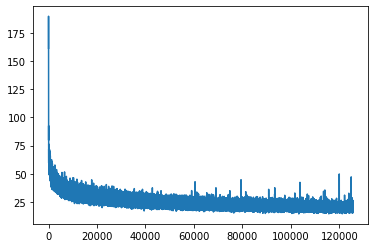

epoch: 68 	 step:0 	 loss: 18.55
epoch: 68 	 step:100 	 loss: 20.45
epoch: 68 	 step:200 	 loss: 20.01
epoch: 68 	 step:300 	 loss: 17.01
epoch: 68 	 step:400 	 loss: 18.58
epoch: 68 	 step:500 	 loss: 16.49
epoch: 68 	 step:600 	 loss: 20.53
epoch: 68 	 step:700 	 loss: 20.74
epoch: 68 	 step:800 	 loss: 19.99
epoch: 68 	 step:900 	 loss: 18.81
epoch: 68 	 step:1000 	 loss: 23.46
epoch: 68 	 step:1100 	 loss: 20.38
epoch: 68 	 step:1200 	 loss: 18.44
epoch: 68 	 step:1300 	 loss: 19.84
epoch: 68 	 step:1400 	 loss: 19.98
epoch: 68 	 step:1500 	 loss: 18.95
epoch: 68 	 step:1600 	 loss: 20.35
epoch: 68 	 step:1700 	 loss: 18.68
epoch: 68 	 step:1800 	 loss: 20.36


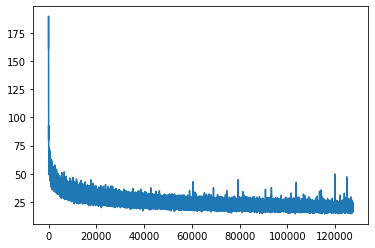

epoch: 69 	 step:0 	 loss: 21.39
epoch: 69 	 step:100 	 loss: 20.29
epoch: 69 	 step:200 	 loss: 19.56
epoch: 69 	 step:300 	 loss: 19.43
epoch: 69 	 step:400 	 loss: 20.14
epoch: 69 	 step:500 	 loss: 18.33
epoch: 69 	 step:600 	 loss: 18.79
epoch: 69 	 step:700 	 loss: 19.8
epoch: 69 	 step:800 	 loss: 19.3
epoch: 69 	 step:900 	 loss: 20.01
epoch: 69 	 step:1000 	 loss: 16.5
epoch: 69 	 step:1100 	 loss: 18.06
epoch: 69 	 step:1200 	 loss: 16.51
epoch: 69 	 step:1300 	 loss: 17.55
epoch: 69 	 step:1400 	 loss: 24.11
epoch: 69 	 step:1500 	 loss: 17.76
epoch: 69 	 step:1600 	 loss: 17.74
epoch: 69 	 step:1700 	 loss: 16.59
epoch: 69 	 step:1800 	 loss: 22.14


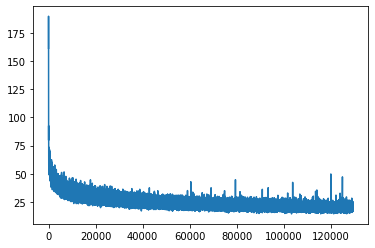

epoch: 70 	 step:0 	 loss: 21.06
epoch: 70 	 step:100 	 loss: 21.09
epoch: 70 	 step:200 	 loss: 17.29
epoch: 70 	 step:300 	 loss: 18.39
epoch: 70 	 step:400 	 loss: 17.15
epoch: 70 	 step:500 	 loss: 18.59
epoch: 70 	 step:600 	 loss: 18.53
epoch: 70 	 step:700 	 loss: 20.37
epoch: 70 	 step:800 	 loss: 19.74
epoch: 70 	 step:900 	 loss: 18.7
epoch: 70 	 step:1000 	 loss: 20.96
epoch: 70 	 step:1100 	 loss: 15.76
epoch: 70 	 step:1200 	 loss: 21.25
epoch: 70 	 step:1300 	 loss: 19.63
epoch: 70 	 step:1400 	 loss: 21.17
epoch: 70 	 step:1500 	 loss: 22.72
epoch: 70 	 step:1600 	 loss: 21.95
epoch: 70 	 step:1700 	 loss: 18.25
epoch: 70 	 step:1800 	 loss: 17.43


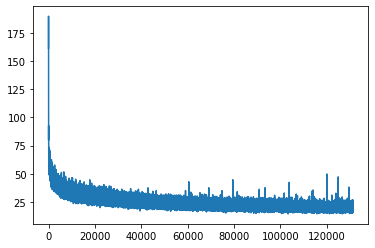

epoch: 71 	 step:0 	 loss: 20.99
epoch: 71 	 step:100 	 loss: 22.48
epoch: 71 	 step:200 	 loss: 21.31
epoch: 71 	 step:300 	 loss: 18.39
epoch: 71 	 step:400 	 loss: 16.75
epoch: 71 	 step:500 	 loss: 21.73
epoch: 71 	 step:600 	 loss: 18.99
epoch: 71 	 step:700 	 loss: 18.45
epoch: 71 	 step:800 	 loss: 18.61
epoch: 71 	 step:900 	 loss: 21.62
epoch: 71 	 step:1000 	 loss: 16.64
epoch: 71 	 step:1100 	 loss: 19.26
epoch: 71 	 step:1200 	 loss: 20.23
epoch: 71 	 step:1300 	 loss: 21.46
epoch: 71 	 step:1400 	 loss: 21.63
epoch: 71 	 step:1500 	 loss: 23.54
epoch: 71 	 step:1600 	 loss: 20.04
epoch: 71 	 step:1700 	 loss: 17.54
epoch: 71 	 step:1800 	 loss: 20.37


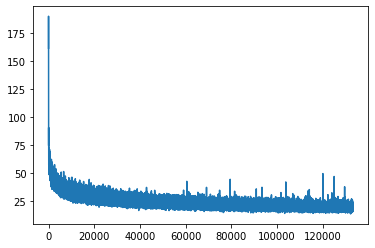

epoch: 72 	 step:0 	 loss: 16.79
epoch: 72 	 step:100 	 loss: 20.11
epoch: 72 	 step:200 	 loss: 15.94
epoch: 72 	 step:300 	 loss: 20.37
epoch: 72 	 step:400 	 loss: 18.82
epoch: 72 	 step:500 	 loss: 19.62
epoch: 72 	 step:600 	 loss: 18.93
epoch: 72 	 step:700 	 loss: 17.11
epoch: 72 	 step:800 	 loss: 18.86
epoch: 72 	 step:900 	 loss: 17.81
epoch: 72 	 step:1000 	 loss: 18.4
epoch: 72 	 step:1100 	 loss: 17.23
epoch: 72 	 step:1200 	 loss: 20.72
epoch: 72 	 step:1300 	 loss: 20.72
epoch: 72 	 step:1400 	 loss: 17.81
epoch: 72 	 step:1500 	 loss: 20.63
epoch: 72 	 step:1600 	 loss: 18.79
epoch: 72 	 step:1700 	 loss: 19.81
epoch: 72 	 step:1800 	 loss: 24.2


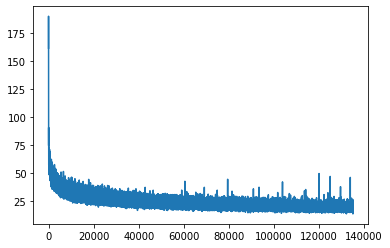

epoch: 73 	 step:0 	 loss: 17.78
epoch: 73 	 step:100 	 loss: 18.22
epoch: 73 	 step:200 	 loss: 21.08
epoch: 73 	 step:300 	 loss: 19.98
epoch: 73 	 step:400 	 loss: 22.01
epoch: 73 	 step:500 	 loss: 20.31
epoch: 73 	 step:600 	 loss: 16.42
epoch: 73 	 step:700 	 loss: 18.83
epoch: 73 	 step:800 	 loss: 19.13
epoch: 73 	 step:900 	 loss: 18.4
epoch: 73 	 step:1000 	 loss: 20.29
epoch: 73 	 step:1100 	 loss: 17.3
epoch: 73 	 step:1200 	 loss: 19.18
epoch: 73 	 step:1300 	 loss: 17.82
epoch: 73 	 step:1400 	 loss: 17.08
epoch: 73 	 step:1500 	 loss: 19.9
epoch: 73 	 step:1600 	 loss: 16.84
epoch: 73 	 step:1700 	 loss: 19.29
epoch: 73 	 step:1800 	 loss: 18.81


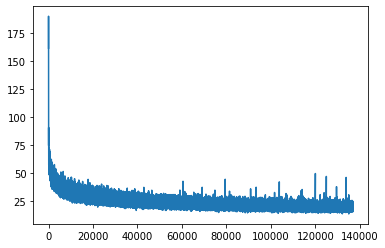

epoch: 74 	 step:0 	 loss: 19.42
epoch: 74 	 step:100 	 loss: 20.18
epoch: 74 	 step:200 	 loss: 20.73
epoch: 74 	 step:300 	 loss: 15.69
epoch: 74 	 step:400 	 loss: 18.46
epoch: 74 	 step:500 	 loss: 16.84
epoch: 74 	 step:600 	 loss: 19.07
epoch: 74 	 step:700 	 loss: 18.41
epoch: 74 	 step:800 	 loss: 20.7
epoch: 74 	 step:900 	 loss: 18.4
epoch: 74 	 step:1000 	 loss: 17.41
epoch: 74 	 step:1100 	 loss: 18.22
epoch: 74 	 step:1200 	 loss: 20.62
epoch: 74 	 step:1300 	 loss: 16.12
epoch: 74 	 step:1400 	 loss: 18.87
epoch: 74 	 step:1500 	 loss: 17.57
epoch: 74 	 step:1600 	 loss: 17.66
epoch: 74 	 step:1700 	 loss: 19.94
epoch: 74 	 step:1800 	 loss: 20.01


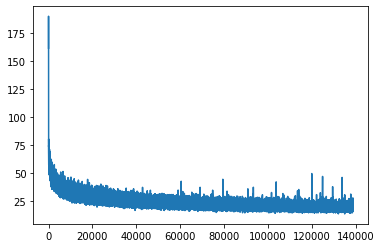

epoch: 75 	 step:0 	 loss: 21.23
epoch: 75 	 step:100 	 loss: 21.05
epoch: 75 	 step:200 	 loss: 16.83
epoch: 75 	 step:300 	 loss: 19.87
epoch: 75 	 step:400 	 loss: 19.65
epoch: 75 	 step:500 	 loss: 18.37
epoch: 75 	 step:600 	 loss: 18.93
epoch: 75 	 step:700 	 loss: 19.84
epoch: 75 	 step:800 	 loss: 18.01
epoch: 75 	 step:900 	 loss: 16.73
epoch: 75 	 step:1000 	 loss: 23.36
epoch: 75 	 step:1100 	 loss: 16.57
epoch: 75 	 step:1200 	 loss: 17.17
epoch: 75 	 step:1300 	 loss: 19.87
epoch: 75 	 step:1400 	 loss: 20.18
epoch: 75 	 step:1500 	 loss: 20.26
epoch: 75 	 step:1600 	 loss: 17.53
epoch: 75 	 step:1700 	 loss: 20.33
epoch: 75 	 step:1800 	 loss: 17.8


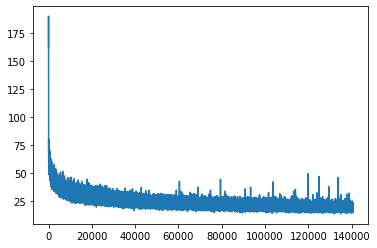

epoch: 76 	 step:0 	 loss: 16.9
epoch: 76 	 step:100 	 loss: 18.91
epoch: 76 	 step:200 	 loss: 17.0
epoch: 76 	 step:300 	 loss: 17.71
epoch: 76 	 step:400 	 loss: 19.46
epoch: 76 	 step:500 	 loss: 21.08
epoch: 76 	 step:600 	 loss: 18.88
epoch: 76 	 step:700 	 loss: 22.9
epoch: 76 	 step:800 	 loss: 21.34
epoch: 76 	 step:900 	 loss: 20.78
epoch: 76 	 step:1000 	 loss: 20.36
epoch: 76 	 step:1100 	 loss: 21.11
epoch: 76 	 step:1200 	 loss: 17.98
epoch: 76 	 step:1300 	 loss: 18.89
epoch: 76 	 step:1400 	 loss: 17.94
epoch: 76 	 step:1500 	 loss: 18.94
epoch: 76 	 step:1600 	 loss: 21.35
epoch: 76 	 step:1700 	 loss: 18.84
epoch: 76 	 step:1800 	 loss: 18.44


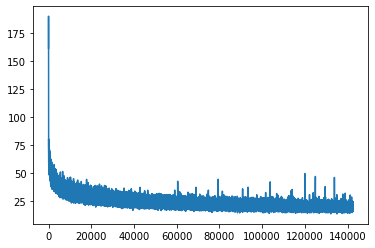

epoch: 77 	 step:0 	 loss: 17.67
epoch: 77 	 step:100 	 loss: 17.02
epoch: 77 	 step:200 	 loss: 19.21
epoch: 77 	 step:300 	 loss: 18.58
epoch: 77 	 step:400 	 loss: 20.34
epoch: 77 	 step:500 	 loss: 18.57
epoch: 77 	 step:600 	 loss: 22.39
epoch: 77 	 step:700 	 loss: 18.06
epoch: 77 	 step:800 	 loss: 22.26
epoch: 77 	 step:900 	 loss: 18.47
epoch: 77 	 step:1000 	 loss: 19.34
epoch: 77 	 step:1100 	 loss: 21.83
epoch: 77 	 step:1200 	 loss: 17.36
epoch: 77 	 step:1300 	 loss: 19.43
epoch: 77 	 step:1400 	 loss: 21.84
epoch: 77 	 step:1500 	 loss: 17.74
epoch: 77 	 step:1600 	 loss: 21.49
epoch: 77 	 step:1700 	 loss: 19.59
epoch: 77 	 step:1800 	 loss: 18.46


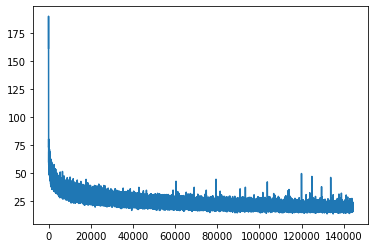

epoch: 78 	 step:0 	 loss: 18.66
epoch: 78 	 step:100 	 loss: 20.15
epoch: 78 	 step:200 	 loss: 16.67
epoch: 78 	 step:300 	 loss: 16.74
epoch: 78 	 step:400 	 loss: 19.43
epoch: 78 	 step:500 	 loss: 15.74
epoch: 78 	 step:600 	 loss: 20.82
epoch: 78 	 step:700 	 loss: 15.95
epoch: 78 	 step:800 	 loss: 21.37
epoch: 78 	 step:900 	 loss: 18.73
epoch: 78 	 step:1000 	 loss: 19.62
epoch: 78 	 step:1100 	 loss: 18.25
epoch: 78 	 step:1200 	 loss: 17.99
epoch: 78 	 step:1300 	 loss: 17.06
epoch: 78 	 step:1400 	 loss: 20.68
epoch: 78 	 step:1500 	 loss: 19.42
epoch: 78 	 step:1600 	 loss: 17.45
epoch: 78 	 step:1700 	 loss: 20.84
epoch: 78 	 step:1800 	 loss: 19.12


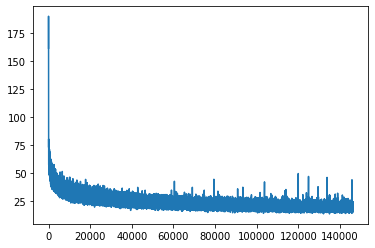

epoch: 79 	 step:0 	 loss: 23.73
epoch: 79 	 step:100 	 loss: 19.09
epoch: 79 	 step:200 	 loss: 18.78
epoch: 79 	 step:300 	 loss: 16.61
epoch: 79 	 step:400 	 loss: 18.69
epoch: 79 	 step:500 	 loss: 18.49
epoch: 79 	 step:600 	 loss: 17.45
epoch: 79 	 step:700 	 loss: 19.89
epoch: 79 	 step:800 	 loss: 19.03
epoch: 79 	 step:900 	 loss: 20.79
epoch: 79 	 step:1000 	 loss: 26.12
epoch: 79 	 step:1100 	 loss: 19.69
epoch: 79 	 step:1200 	 loss: 21.28
epoch: 79 	 step:1300 	 loss: 26.52
epoch: 79 	 step:1400 	 loss: 17.06
epoch: 79 	 step:1500 	 loss: 16.84
epoch: 79 	 step:1600 	 loss: 17.24
epoch: 79 	 step:1700 	 loss: 17.44
epoch: 79 	 step:1800 	 loss: 20.37


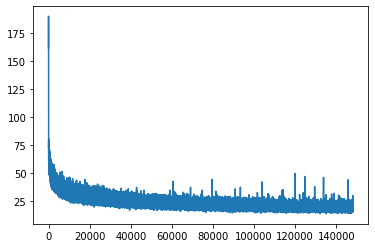

epoch: 80 	 step:0 	 loss: 21.02
epoch: 80 	 step:100 	 loss: 17.83
epoch: 80 	 step:200 	 loss: 21.57
epoch: 80 	 step:300 	 loss: 17.9
epoch: 80 	 step:400 	 loss: 17.46
epoch: 80 	 step:500 	 loss: 19.04
epoch: 80 	 step:600 	 loss: 15.62
epoch: 80 	 step:700 	 loss: 17.63
epoch: 80 	 step:800 	 loss: 20.33
epoch: 80 	 step:900 	 loss: 18.09
epoch: 80 	 step:1000 	 loss: 20.73
epoch: 80 	 step:1100 	 loss: 18.65
epoch: 80 	 step:1200 	 loss: 16.78
epoch: 80 	 step:1300 	 loss: 19.38
epoch: 80 	 step:1400 	 loss: 17.58
epoch: 80 	 step:1500 	 loss: 18.11
epoch: 80 	 step:1600 	 loss: 20.18
epoch: 80 	 step:1700 	 loss: 19.35
epoch: 80 	 step:1800 	 loss: 17.83


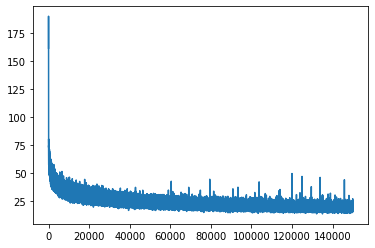

epoch: 81 	 step:0 	 loss: 17.15
epoch: 81 	 step:100 	 loss: 19.31
epoch: 81 	 step:200 	 loss: 16.99
epoch: 81 	 step:300 	 loss: 17.12
epoch: 81 	 step:400 	 loss: 20.32
epoch: 81 	 step:500 	 loss: 21.74
epoch: 81 	 step:600 	 loss: 18.87
epoch: 81 	 step:700 	 loss: 17.64
epoch: 81 	 step:800 	 loss: 15.83
epoch: 81 	 step:900 	 loss: 16.64
epoch: 81 	 step:1000 	 loss: 20.81
epoch: 81 	 step:1100 	 loss: 17.71
epoch: 81 	 step:1200 	 loss: 20.59
epoch: 81 	 step:1300 	 loss: 20.02
epoch: 81 	 step:1400 	 loss: 23.17
epoch: 81 	 step:1500 	 loss: 17.74
epoch: 81 	 step:1600 	 loss: 18.34
epoch: 81 	 step:1700 	 loss: 17.03
epoch: 81 	 step:1800 	 loss: 16.75


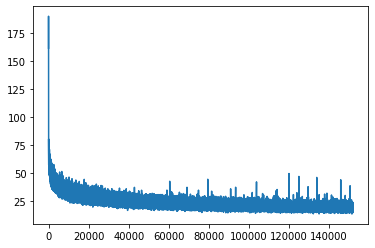

epoch: 82 	 step:0 	 loss: 20.12
epoch: 82 	 step:100 	 loss: 19.36
epoch: 82 	 step:200 	 loss: 22.02
epoch: 82 	 step:300 	 loss: 17.06
epoch: 82 	 step:400 	 loss: 18.64
epoch: 82 	 step:500 	 loss: 19.72
epoch: 82 	 step:600 	 loss: 17.75
epoch: 82 	 step:700 	 loss: 17.96
epoch: 82 	 step:800 	 loss: 17.67
epoch: 82 	 step:900 	 loss: 20.54
epoch: 82 	 step:1000 	 loss: 18.19
epoch: 82 	 step:1100 	 loss: 15.99
epoch: 82 	 step:1200 	 loss: 20.05
epoch: 82 	 step:1300 	 loss: 17.43
epoch: 82 	 step:1400 	 loss: 18.87
epoch: 82 	 step:1500 	 loss: 17.15
epoch: 82 	 step:1600 	 loss: 20.83
epoch: 82 	 step:1700 	 loss: 19.11
epoch: 82 	 step:1800 	 loss: 21.03


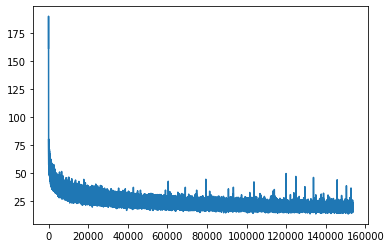

epoch: 83 	 step:0 	 loss: 17.71
epoch: 83 	 step:100 	 loss: 20.04
epoch: 83 	 step:200 	 loss: 16.98
epoch: 83 	 step:300 	 loss: 15.06
epoch: 83 	 step:400 	 loss: 20.13
epoch: 83 	 step:500 	 loss: 19.45
epoch: 83 	 step:600 	 loss: 16.43
epoch: 83 	 step:700 	 loss: 24.34
epoch: 83 	 step:800 	 loss: 16.67
epoch: 83 	 step:900 	 loss: 18.96
epoch: 83 	 step:1000 	 loss: 20.05
epoch: 83 	 step:1100 	 loss: 19.22
epoch: 83 	 step:1200 	 loss: 22.17
epoch: 83 	 step:1300 	 loss: 16.9
epoch: 83 	 step:1400 	 loss: 19.47
epoch: 83 	 step:1500 	 loss: 18.7
epoch: 83 	 step:1600 	 loss: 18.66
epoch: 83 	 step:1700 	 loss: 19.74
epoch: 83 	 step:1800 	 loss: 18.81


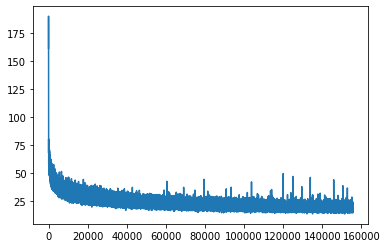

epoch: 84 	 step:0 	 loss: 18.48
epoch: 84 	 step:100 	 loss: 20.35
epoch: 84 	 step:200 	 loss: 17.55
epoch: 84 	 step:300 	 loss: 20.62
epoch: 84 	 step:400 	 loss: 18.59
epoch: 84 	 step:500 	 loss: 19.66
epoch: 84 	 step:600 	 loss: 19.65
epoch: 84 	 step:700 	 loss: 17.35
epoch: 84 	 step:800 	 loss: 20.36
epoch: 84 	 step:900 	 loss: 19.72
epoch: 84 	 step:1000 	 loss: 18.54
epoch: 84 	 step:1100 	 loss: 17.55
epoch: 84 	 step:1200 	 loss: 19.57
epoch: 84 	 step:1300 	 loss: 18.68
epoch: 84 	 step:1400 	 loss: 21.14
epoch: 84 	 step:1500 	 loss: 18.38
epoch: 84 	 step:1600 	 loss: 19.9
epoch: 84 	 step:1700 	 loss: 19.29
epoch: 84 	 step:1800 	 loss: 14.79


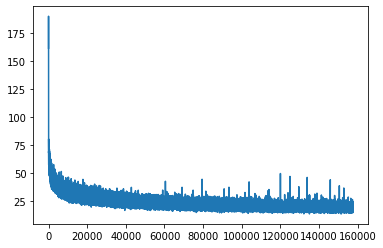

epoch: 85 	 step:0 	 loss: 17.74
epoch: 85 	 step:100 	 loss: 21.69
epoch: 85 	 step:200 	 loss: 19.68
epoch: 85 	 step:300 	 loss: 18.53
epoch: 85 	 step:400 	 loss: 18.64
epoch: 85 	 step:500 	 loss: 21.62
epoch: 85 	 step:600 	 loss: 20.86
epoch: 85 	 step:700 	 loss: 18.77
epoch: 85 	 step:800 	 loss: 20.19
epoch: 85 	 step:900 	 loss: 17.95
epoch: 85 	 step:1000 	 loss: 19.26
epoch: 85 	 step:1100 	 loss: 19.77
epoch: 85 	 step:1200 	 loss: 18.3
epoch: 85 	 step:1300 	 loss: 18.45
epoch: 85 	 step:1400 	 loss: 19.38
epoch: 85 	 step:1500 	 loss: 19.69
epoch: 85 	 step:1600 	 loss: 18.95
epoch: 85 	 step:1700 	 loss: 17.65
epoch: 85 	 step:1800 	 loss: 19.51


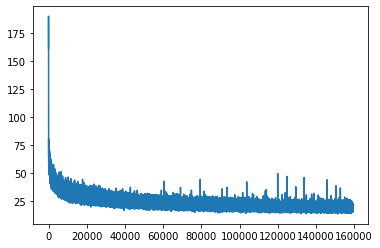

epoch: 86 	 step:0 	 loss: 21.64
epoch: 86 	 step:100 	 loss: 27.07
epoch: 86 	 step:200 	 loss: 16.85
epoch: 86 	 step:300 	 loss: 17.67
epoch: 86 	 step:400 	 loss: 20.34
epoch: 86 	 step:500 	 loss: 19.27
epoch: 86 	 step:600 	 loss: 17.51
epoch: 86 	 step:700 	 loss: 16.61
epoch: 86 	 step:800 	 loss: 19.72
epoch: 86 	 step:900 	 loss: 17.14
epoch: 86 	 step:1000 	 loss: 18.36
epoch: 86 	 step:1100 	 loss: 20.79
epoch: 86 	 step:1200 	 loss: 18.66
epoch: 86 	 step:1300 	 loss: 19.96
epoch: 86 	 step:1400 	 loss: 17.63
epoch: 86 	 step:1500 	 loss: 19.31
epoch: 86 	 step:1600 	 loss: 16.42
epoch: 86 	 step:1700 	 loss: 19.76
epoch: 86 	 step:1800 	 loss: 19.59


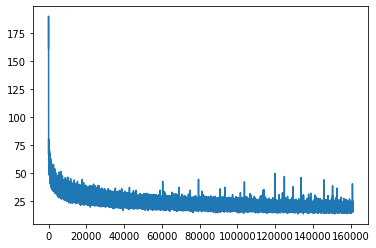

epoch: 87 	 step:0 	 loss: 18.54
epoch: 87 	 step:100 	 loss: 17.31
epoch: 87 	 step:200 	 loss: 15.47
epoch: 87 	 step:300 	 loss: 17.93
epoch: 87 	 step:400 	 loss: 16.89
epoch: 87 	 step:500 	 loss: 17.9
epoch: 87 	 step:600 	 loss: 18.52
epoch: 87 	 step:700 	 loss: 18.48
epoch: 87 	 step:800 	 loss: 22.67
epoch: 87 	 step:900 	 loss: 18.62
epoch: 87 	 step:1000 	 loss: 18.71
epoch: 87 	 step:1100 	 loss: 18.59
epoch: 87 	 step:1200 	 loss: 22.61
epoch: 87 	 step:1300 	 loss: 16.92
epoch: 87 	 step:1400 	 loss: 19.85
epoch: 87 	 step:1500 	 loss: 19.42
epoch: 87 	 step:1600 	 loss: 17.02
epoch: 87 	 step:1700 	 loss: 16.86
epoch: 87 	 step:1800 	 loss: 21.11


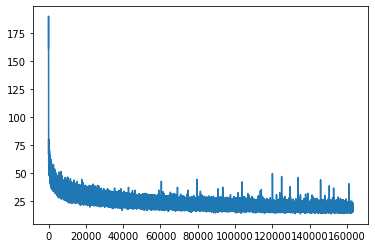

epoch: 88 	 step:0 	 loss: 17.51
epoch: 88 	 step:100 	 loss: 18.23
epoch: 88 	 step:200 	 loss: 22.49
epoch: 88 	 step:300 	 loss: 19.45
epoch: 88 	 step:400 	 loss: 17.76
epoch: 88 	 step:500 	 loss: 17.07
epoch: 88 	 step:600 	 loss: 18.1
epoch: 88 	 step:700 	 loss: 18.19
epoch: 88 	 step:800 	 loss: 19.49
epoch: 88 	 step:900 	 loss: 21.02
epoch: 88 	 step:1000 	 loss: 23.97
epoch: 88 	 step:1100 	 loss: 18.87
epoch: 88 	 step:1200 	 loss: 19.35
epoch: 88 	 step:1300 	 loss: 16.49
epoch: 88 	 step:1400 	 loss: 17.61
epoch: 88 	 step:1500 	 loss: 17.96
epoch: 88 	 step:1600 	 loss: 18.83
epoch: 88 	 step:1700 	 loss: 19.7
epoch: 88 	 step:1800 	 loss: 18.55


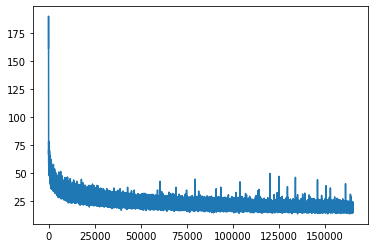

epoch: 89 	 step:0 	 loss: 18.25
epoch: 89 	 step:100 	 loss: 17.09
epoch: 89 	 step:200 	 loss: 17.62
epoch: 89 	 step:300 	 loss: 20.11
epoch: 89 	 step:400 	 loss: 21.97
epoch: 89 	 step:500 	 loss: 16.11
epoch: 89 	 step:600 	 loss: 18.03
epoch: 89 	 step:700 	 loss: 20.42
epoch: 89 	 step:800 	 loss: 20.91
epoch: 89 	 step:900 	 loss: 19.08
epoch: 89 	 step:1000 	 loss: 17.69
epoch: 89 	 step:1100 	 loss: 18.35
epoch: 89 	 step:1200 	 loss: 17.57
epoch: 89 	 step:1300 	 loss: 21.17
epoch: 89 	 step:1400 	 loss: 16.39
epoch: 89 	 step:1500 	 loss: 19.13
epoch: 89 	 step:1600 	 loss: 20.06
epoch: 89 	 step:1700 	 loss: 16.66
epoch: 89 	 step:1800 	 loss: 22.21


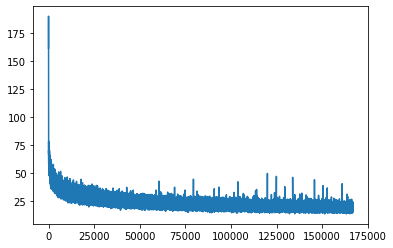

epoch: 90 	 step:0 	 loss: 18.65
epoch: 90 	 step:100 	 loss: 16.64
epoch: 90 	 step:200 	 loss: 21.28
epoch: 90 	 step:300 	 loss: 17.82
epoch: 90 	 step:400 	 loss: 17.73
epoch: 90 	 step:500 	 loss: 17.63
epoch: 90 	 step:600 	 loss: 16.64
epoch: 90 	 step:700 	 loss: 16.8
epoch: 90 	 step:800 	 loss: 23.95
epoch: 90 	 step:900 	 loss: 18.05
epoch: 90 	 step:1000 	 loss: 16.82
epoch: 90 	 step:1100 	 loss: 20.39
epoch: 90 	 step:1200 	 loss: 19.44
epoch: 90 	 step:1300 	 loss: 20.44
epoch: 90 	 step:1400 	 loss: 19.08
epoch: 90 	 step:1500 	 loss: 18.53
epoch: 90 	 step:1600 	 loss: 18.54
epoch: 90 	 step:1700 	 loss: 19.57
epoch: 90 	 step:1800 	 loss: 19.73


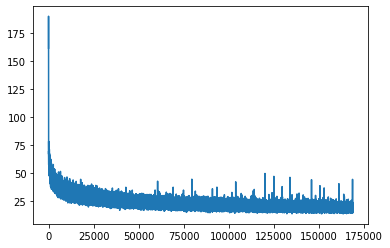

epoch: 91 	 step:0 	 loss: 18.7
epoch: 91 	 step:100 	 loss: 20.34
epoch: 91 	 step:200 	 loss: 17.3
epoch: 91 	 step:300 	 loss: 17.84
epoch: 91 	 step:400 	 loss: 23.58
epoch: 91 	 step:500 	 loss: 17.64
epoch: 91 	 step:600 	 loss: 18.83
epoch: 91 	 step:700 	 loss: 16.97
epoch: 91 	 step:800 	 loss: 23.09
epoch: 91 	 step:900 	 loss: 22.17
epoch: 91 	 step:1000 	 loss: 17.19
epoch: 91 	 step:1100 	 loss: 18.66
epoch: 91 	 step:1200 	 loss: 17.58
epoch: 91 	 step:1300 	 loss: 18.34
epoch: 91 	 step:1400 	 loss: 19.46
epoch: 91 	 step:1500 	 loss: 19.69
epoch: 91 	 step:1600 	 loss: 21.26
epoch: 91 	 step:1700 	 loss: 18.48
epoch: 91 	 step:1800 	 loss: 20.12


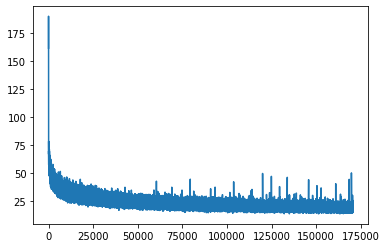

epoch: 92 	 step:0 	 loss: 19.95
epoch: 92 	 step:100 	 loss: 21.63
epoch: 92 	 step:200 	 loss: 16.75
epoch: 92 	 step:300 	 loss: 18.88
epoch: 92 	 step:400 	 loss: 15.8
epoch: 92 	 step:500 	 loss: 18.92
epoch: 92 	 step:600 	 loss: 16.34
epoch: 92 	 step:700 	 loss: 17.88
epoch: 92 	 step:800 	 loss: 15.18
epoch: 92 	 step:900 	 loss: 19.87
epoch: 92 	 step:1000 	 loss: 20.39
epoch: 92 	 step:1100 	 loss: 19.62
epoch: 92 	 step:1200 	 loss: 22.01
epoch: 92 	 step:1300 	 loss: 18.8
epoch: 92 	 step:1400 	 loss: 19.39
epoch: 92 	 step:1500 	 loss: 16.78
epoch: 92 	 step:1600 	 loss: 19.87
epoch: 92 	 step:1700 	 loss: 18.09
epoch: 92 	 step:1800 	 loss: 18.56


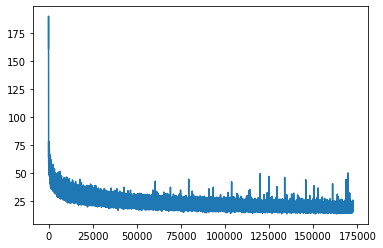

epoch: 93 	 step:0 	 loss: 18.76
epoch: 93 	 step:100 	 loss: 17.59
epoch: 93 	 step:200 	 loss: 16.7
epoch: 93 	 step:300 	 loss: 15.33
epoch: 93 	 step:400 	 loss: 18.38
epoch: 93 	 step:500 	 loss: 16.49
epoch: 93 	 step:600 	 loss: 15.23
epoch: 93 	 step:700 	 loss: 18.44
epoch: 93 	 step:800 	 loss: 16.77
epoch: 93 	 step:900 	 loss: 20.92
epoch: 93 	 step:1000 	 loss: 18.28
epoch: 93 	 step:1100 	 loss: 16.82
epoch: 93 	 step:1200 	 loss: 21.58
epoch: 93 	 step:1300 	 loss: 19.14
epoch: 93 	 step:1400 	 loss: 18.25
epoch: 93 	 step:1500 	 loss: 16.24
epoch: 93 	 step:1600 	 loss: 17.14
epoch: 93 	 step:1700 	 loss: 16.62
epoch: 93 	 step:1800 	 loss: 19.08


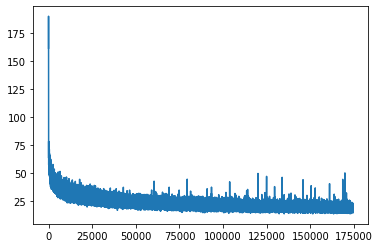

epoch: 94 	 step:0 	 loss: 22.35
epoch: 94 	 step:100 	 loss: 19.25
epoch: 94 	 step:200 	 loss: 17.46
epoch: 94 	 step:300 	 loss: 20.2
epoch: 94 	 step:400 	 loss: 17.6
epoch: 94 	 step:500 	 loss: 17.85
epoch: 94 	 step:600 	 loss: 20.71
epoch: 94 	 step:700 	 loss: 17.75
epoch: 94 	 step:800 	 loss: 20.99
epoch: 94 	 step:900 	 loss: 19.56
epoch: 94 	 step:1000 	 loss: 16.63
epoch: 94 	 step:1100 	 loss: 17.34
epoch: 94 	 step:1200 	 loss: 19.44
epoch: 94 	 step:1300 	 loss: 20.42
epoch: 94 	 step:1400 	 loss: 17.81
epoch: 94 	 step:1500 	 loss: 18.62
epoch: 94 	 step:1600 	 loss: 17.66
epoch: 94 	 step:1700 	 loss: 18.49
epoch: 94 	 step:1800 	 loss: 18.18


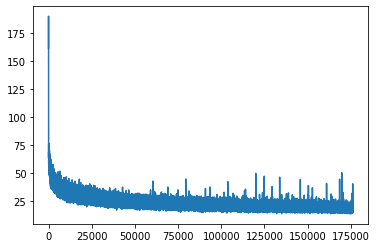

epoch: 95 	 step:0 	 loss: 19.16
epoch: 95 	 step:100 	 loss: 17.62
epoch: 95 	 step:200 	 loss: 17.4
epoch: 95 	 step:300 	 loss: 19.03
epoch: 95 	 step:400 	 loss: 17.1
epoch: 95 	 step:500 	 loss: 20.32
epoch: 95 	 step:600 	 loss: 17.11
epoch: 95 	 step:700 	 loss: 16.22
epoch: 95 	 step:800 	 loss: 17.65
epoch: 95 	 step:900 	 loss: 16.44
epoch: 95 	 step:1000 	 loss: 19.67
epoch: 95 	 step:1100 	 loss: 19.48
epoch: 95 	 step:1200 	 loss: 16.79
epoch: 95 	 step:1300 	 loss: 21.6
epoch: 95 	 step:1400 	 loss: 17.6
epoch: 95 	 step:1500 	 loss: 18.03
epoch: 95 	 step:1600 	 loss: 20.69
epoch: 95 	 step:1700 	 loss: 17.26
epoch: 95 	 step:1800 	 loss: 17.33


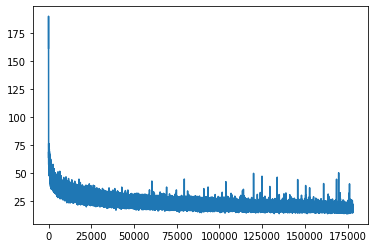

epoch: 96 	 step:0 	 loss: 17.76
epoch: 96 	 step:100 	 loss: 18.96
epoch: 96 	 step:200 	 loss: 17.73
epoch: 96 	 step:300 	 loss: 17.84
epoch: 96 	 step:400 	 loss: 16.41
epoch: 96 	 step:500 	 loss: 18.14
epoch: 96 	 step:600 	 loss: 18.48
epoch: 96 	 step:700 	 loss: 16.29
epoch: 96 	 step:800 	 loss: 19.87
epoch: 96 	 step:900 	 loss: 16.06
epoch: 96 	 step:1000 	 loss: 18.08
epoch: 96 	 step:1100 	 loss: 17.97
epoch: 96 	 step:1200 	 loss: 18.38
epoch: 96 	 step:1300 	 loss: 16.15
epoch: 96 	 step:1400 	 loss: 18.16
epoch: 96 	 step:1500 	 loss: 19.15
epoch: 96 	 step:1600 	 loss: 20.47
epoch: 96 	 step:1700 	 loss: 17.64
epoch: 96 	 step:1800 	 loss: 18.35


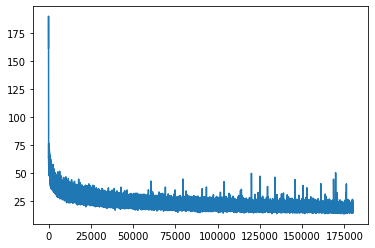

epoch: 97 	 step:0 	 loss: 18.28
epoch: 97 	 step:100 	 loss: 17.35
epoch: 97 	 step:200 	 loss: 17.78
epoch: 97 	 step:300 	 loss: 21.98
epoch: 97 	 step:400 	 loss: 16.22
epoch: 97 	 step:500 	 loss: 20.51
epoch: 97 	 step:600 	 loss: 17.0
epoch: 97 	 step:700 	 loss: 18.23
epoch: 97 	 step:800 	 loss: 16.17
epoch: 97 	 step:900 	 loss: 18.49
epoch: 97 	 step:1000 	 loss: 15.6
epoch: 97 	 step:1100 	 loss: 19.15
epoch: 97 	 step:1200 	 loss: 22.38
epoch: 97 	 step:1300 	 loss: 17.84
epoch: 97 	 step:1400 	 loss: 18.43
epoch: 97 	 step:1500 	 loss: 17.47
epoch: 97 	 step:1600 	 loss: 18.9
epoch: 97 	 step:1700 	 loss: 18.37
epoch: 97 	 step:1800 	 loss: 19.53


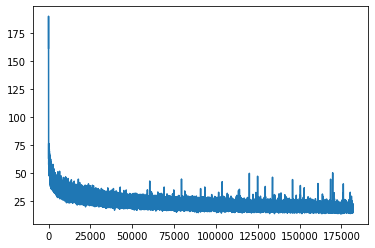

epoch: 98 	 step:0 	 loss: 16.84
epoch: 98 	 step:100 	 loss: 16.16
epoch: 98 	 step:200 	 loss: 16.71
epoch: 98 	 step:300 	 loss: 16.79
epoch: 98 	 step:400 	 loss: 18.62
epoch: 98 	 step:500 	 loss: 16.66
epoch: 98 	 step:600 	 loss: 20.92
epoch: 98 	 step:700 	 loss: 19.15
epoch: 98 	 step:800 	 loss: 16.91
epoch: 98 	 step:900 	 loss: 17.42
epoch: 98 	 step:1000 	 loss: 17.72
epoch: 98 	 step:1100 	 loss: 15.06
epoch: 98 	 step:1200 	 loss: 17.83
epoch: 98 	 step:1300 	 loss: 19.11
epoch: 98 	 step:1400 	 loss: 18.05
epoch: 98 	 step:1500 	 loss: 19.44
epoch: 98 	 step:1600 	 loss: 20.85
epoch: 98 	 step:1700 	 loss: 17.42
epoch: 98 	 step:1800 	 loss: 18.52


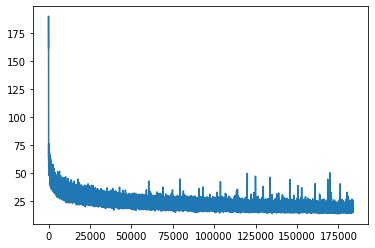

epoch: 99 	 step:0 	 loss: 16.96
epoch: 99 	 step:100 	 loss: 17.01
epoch: 99 	 step:200 	 loss: 15.93
epoch: 99 	 step:300 	 loss: 18.03
epoch: 99 	 step:400 	 loss: 17.27
epoch: 99 	 step:500 	 loss: 19.1
epoch: 99 	 step:600 	 loss: 19.47
epoch: 99 	 step:700 	 loss: 16.88
epoch: 99 	 step:800 	 loss: 20.21
epoch: 99 	 step:900 	 loss: 17.38
epoch: 99 	 step:1000 	 loss: 14.93
epoch: 99 	 step:1100 	 loss: 16.03
epoch: 99 	 step:1200 	 loss: 18.19
epoch: 99 	 step:1300 	 loss: 18.08
epoch: 99 	 step:1400 	 loss: 18.16
epoch: 99 	 step:1500 	 loss: 16.95
epoch: 99 	 step:1600 	 loss: 17.2
epoch: 99 	 step:1700 	 loss: 19.73
epoch: 99 	 step:1800 	 loss: 16.49


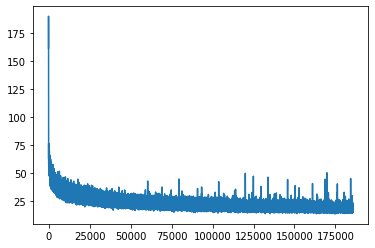

epoch: 100 	 step:0 	 loss: 16.77
epoch: 100 	 step:100 	 loss: 16.5
epoch: 100 	 step:200 	 loss: 17.59
epoch: 100 	 step:300 	 loss: 18.92
epoch: 100 	 step:400 	 loss: 20.72
epoch: 100 	 step:500 	 loss: 18.31
epoch: 100 	 step:600 	 loss: 17.95
epoch: 100 	 step:700 	 loss: 17.2
epoch: 100 	 step:800 	 loss: 17.42
epoch: 100 	 step:900 	 loss: 18.09
epoch: 100 	 step:1000 	 loss: 21.86
epoch: 100 	 step:1100 	 loss: 17.97
epoch: 100 	 step:1200 	 loss: 18.89
epoch: 100 	 step:1300 	 loss: 17.51
epoch: 100 	 step:1400 	 loss: 17.27
epoch: 100 	 step:1500 	 loss: 18.43
epoch: 100 	 step:1600 	 loss: 18.7
epoch: 100 	 step:1700 	 loss: 16.3
epoch: 100 	 step:1800 	 loss: 17.92


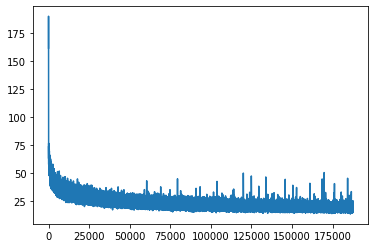

In [18]:
### TRAIN MODEL ###

num_epochs = 100

history = train_model(gen, opt, device, dataloader['train'], epochs=num_epochs)

In [19]:
def test_generator(model, device, testloader, one_batch=False):
    # put model to eval mode
    model = model.to(device=device)
    model.eval()

    # move test images to device and reduce to magnitude information in fourier space
    test_images = []
    outputs = []
    
    for data in testloader:
        data = data.to(device=device)
        test_images.append(data.cpu().numpy())
        magn, _ = calc_fourier(data)
        out_phs = model(magn)
        out_ft = magn[..., None] * torch.stack([torch.cos(out_phs), torch.sin(out_phs)], dim=-1)
        out = torch.irfft(out_ft, 2, onesided=False)
        
        outputs.append(out.cpu().detach().numpy())
        if one_batch: break
    
    return np.concatenate(test_images), np.concatenate(outputs)

In [20]:
# Calculate test predictions #

test_original, test_predicted = test_generator(gen, device, dataloader['test'])
print(test_original.shape)
print(test_predicted.shape)

(8000, 1, 28, 28)
(8000, 1, 28, 28)


Produces negative values!

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


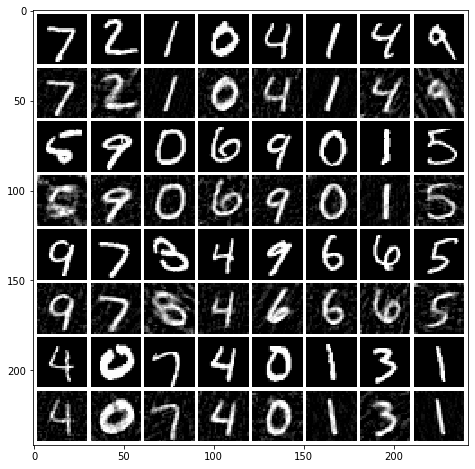

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Registered:


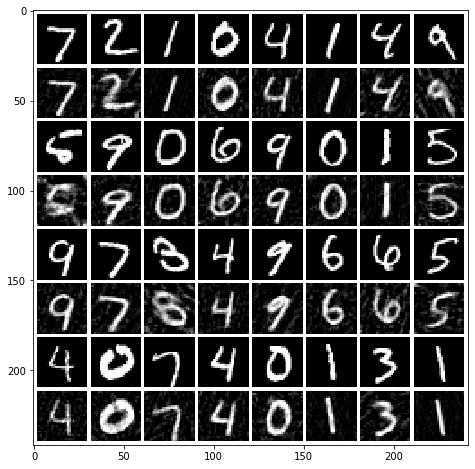

In [21]:
# Print predictions #
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    test_predicted[:32, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/end-to-end/phase-prediction/fourier-dist.png")

print("Registered:")
results_reg = register_croco(test_predicted[:32], test_original[:32])
to_plot = np.stack([test_original[:32, 0].reshape(4, 8, 28, 28), 
                    results_reg[:, 0].reshape(4, 8, 28, 28)], axis=1).reshape(-1, 1, 28, 28)        
plot_grid(to_plot, figsize=(8,8), file="../out/MNIST/end-to-end/phase-prediction/fourier-dist-reg.png")

In [22]:
# Benchmark test predictions #

benchmark(pred=test_predicted[:1024], true=test_original[:1024], check_all=True)

Signal error:
  MSE: 0.03307487403048981, std: 0.02059720348905707
  MAE: 0.12400127089131274, std: 0.03900041016480259
  SSIM: 0.5839077344100165, std: 0.13557360818872016
  Sharpness: 0.20234625217316102, std: 0.04824717069557006
  PhCo-MSE: 0.03585766048513506, std: 0.0305541227490465
  PhCo-MAE: 0.12663159814110259, std: 0.046000168991000116
  PhCo-SSIM: 0.5703490177439683, std: 0.16360493319313257
  CroCo-MSE: 0.027491023121910985, std: 0.01441347204914802
  CroCo-MAE: 0.11685740714528947, std: 0.0339254482080227
  CroCo-SSIM: 0.616011446073895, std: 0.1090365859740334

Magnitude error:
  MSE Magnitude: 0.062489196628163324, std: 0.2090409753157337

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-1.89, 1.58] - should be in [0, 1]

Markdown table values:
 0.03307 | 0.1240 | 0.5839 | 0.2023 | 0.03586 | 0.1266 | 0.5703 | 0.02749 | 0.1169 | 0.6160 | 0.06249 |


## Evaluation for different FC  (1024 samples)

#### Simple L2 squared loss

| Nr | Loss | Size | epochs| MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | L2 | 2048 | 50 | 0.1112 | 0.2296 | 0.2197 | 0.2207 | 0.1287 | 0.2506 | 0.1599 | 0.07924 | 0.2016 | 0.3229 | 0.007572 |
| 1 | L2 | 2048 | 100 | 0.1012 | 0.2218 | 0.2429 | 0.2218 | 0.1261 | 0.2497 | 0.1610 | 0.07691 | 0.2004 | 0.3240 | 0.006812 |

Signal error:
  MSE: 0.10115243768632354, std: 0.049001721406769644
  MAE: 0.2218136843512184, std: 0.05966482306084662
  SSIM: 0.2428516045457293, std: 0.15149807486263805
  Sharpness: 0.22179148183409597, std: 0.054922376385547735
  PhCo-MSE: 0.12606547679024516, std: 0.06663409824060293
  PhCo-MAE: 0.2496589163747558, std: 0.0776083778050697
  PhCo-SSIM: 0.161036403819027, std: 0.15824720300577835
  CroCo-MSE: 0.07691355903443764, std: 0.03354678758228216
  CroCo-MAE: 0.20039818654913688, std: 0.05485128734448625
  CroCo-SSIM: 0.32398880737020763, std: 0.1220890848805521

Magnitude error:
  MSE Magnitude: 0.006811539379924833, std: 0.009746373752577019

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-1.04, 4.47] - should be in [0, 1]

#### Fourier L2 phase dist

| Nr | Loss | Size | epochs| MSE | MAE | SSIM | SHRP | PhaCo-MSE | PhaCo-MAE | PhaCo-SSIM | CroCo-MSE | CroCo-MAE | CroCo-SSIM | MSE Magn
| --- | --- | --- | --- | --- | --- | --- | --- |
| 1 | Fourier dist | 2048 | 50 | 0.03353 | 0.1249 | 0.5846 | 0.2043 | 0.03536 | 0.1266 | 0.5758 | 0.02773 | 0.1176 | 0.6173 | 0.06617 |
| 1 | Fourier dist | 2048 | 100 | 0.03307 | 0.1240 | 0.5839 | 0.2023 | 0.03586 | 0.1266 | 0.5703 | 0.02749 | 0.1169 | 0.6160 | 0.06249 |

Signal error:
  MSE: 0.03307487403048981, std: 0.02059720348905707
  MAE: 0.12400127089131274, std: 0.03900041016480259
  SSIM: 0.5839077344100165, std: 0.13557360818872016
  Sharpness: 0.20234625217316102, std: 0.04824717069557006
  PhCo-MSE: 0.03585766048513506, std: 0.0305541227490465
  PhCo-MAE: 0.12663159814110259, std: 0.046000168991000116
  PhCo-SSIM: 0.5703490177439683, std: 0.16360493319313257
  CroCo-MSE: 0.027491023121910985, std: 0.01441347204914802
  CroCo-MAE: 0.11685740714528947, std: 0.0339254482080227
  CroCo-SSIM: 0.616011446073895, std: 0.1090365859740334

Magnitude error:
  MSE Magnitude: 0.062489196628163324, std: 0.2090409753157337

Image constraints:
  Imag part = 0.0 - should be very close to 0
  Real part is in [-1.89, 1.58] - should be in [0, 1]
